## Mount google drive

In [2]:
# Use drive to manage datasets
from google.colab import drive

# Prompt for authorization
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
project_path = "/content/drive/MyDrive/Projects/Omdena/Agro-Milan/disease-files/"

# Change the current working directory.
%cd "{project_path}"

/content/drive/MyDrive/Projects/Omdena/Agro-Milan/disease-files


In [4]:
!pwd

/content/drive/MyDrive/Projects/Omdena/Agro-Milan/disease-files


## Modeling Task Outline


#### 1. Initial Data Splitting:
- Training Set: Used for training the model.
- Validation Set: Used for tuning hyperparameters and validating the model during training.
- Test Set: Used for the final evaluation of the model after training.

#### 2. Data Augmentation:
- Training Set: Apply data augmentation techniques like rotation, flipping, zooming, and cropping to artificially expand the dataset and introduce variability. This helps the model generalize better.
- Note : Apply augmentation techniques without distorting the pest/disease information in image

#### 3. Model Selection and Architecture:
- Choose a Base Model
- Customize the Model

#### 4. Model Training :
- Compile the Model
- Train the Model
- Hyperparameter Tuning

#### 5. Model Evaluation :
- Evaluate on Test Set
Evaluate the model performance on the unseen test data to get an unbiased estimate of its accuracy.
- Performance Metrics
Use confusion matrix, precision, recall, F1 score, and accuracy to assess the model’s performance.





## Work

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import albumentations as A
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
from torchvision import models
from tqdm import tqdm
from typing import Dict, Tuple, List
import cv2
# from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from albumentations.pytorch import ToTensorV2
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report


### Functions

In [6]:
# CustomDataset class for multi-class image classification
class CustomDataset(Dataset):


    def __init__(self, root_dir: str, split: str, transform=None, resize=None):
        """
        Custom dataset class for multi-class image classification.

        Args:
            root_dir (str): Root directory containing the dataset.
            split (str): Split (e.g., train, validation) of the dataset.
            transform (callable, optional): Optional transformation to apply to the data.
            resize (int, optional): Resize dimensions (width, height) for the images.

        Attributes:
            root_dir (str): Root directory containing the dataset.
            split (str): Split (e.g., train, validation) of the dataset.
            transform (callable, optional): Optional transformation to apply to the data.
            resize (int, optional): Resize dimensions (width, height) for the images.
            data (list): List of image paths.
            targets (list): List of target labels.
            class_names (list): List of class names.
            class_idx_to_name (dict): Dictionary mapping class indices to class names.

        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.resize = resize
        self.data = []
        self.targets = []
        self.class_names = []


        # Determine the data directory based on the split
        data_dir = os.path.join(root_dir, split)

        # Walk through the class subfolders
        class_dirs = sorted(os.listdir(data_dir))
        for class_idx, class_dir in enumerate(class_dirs):
            class_path = os.path.join(data_dir, class_dir)
            self.class_names.append(class_dir)

            # Walk through the images in each class subfolder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.targets.append(class_idx)
        # Create a dictionary to map class indices to class names
        self.class_idx_to_name = {idx: name for idx, name in enumerate(self.class_names)}

        # Method to get the length of the dataset
    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self.data)

    # Method to get a specific item from the dataset
    def __getitem__(self, idx):
        """
        Get a specific item from the dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the processed image and its target label.
                If an error occurs during image loading or processing, returns (None, None).
        """
        img_path = self.data[idx]
        target = self.targets[idx]

        try:
            image = cv2.imread(img_path)

            if self.resize is not None:
                image = cv2.resize(image, (self.resize, self.resize))

            if self.transform is not None:
                image = self.transform(image=image)['image']

            return image, target

        except Exception as e:
            print(f"Error loading image: {e}")
            return None, None

    def num_classes(self):
        """
        Get the number of classes in the dataset.

        Returns:
            int: Number of classes.
        """
        return len(self.class_names)


    def get_class_name(self, class_idx):
        """
        Get the class name based on its index.

        Args:
            class_idx (int): Index of the class.

        Returns:
            str: The name of the class.
        """
        return self.class_idx_to_name.get(class_idx)

    def get_class_names(self):
        """
        Get all class names in the dataset.

        Returns:
            list: A list of class names.
        """
        return list(self.class_idx_to_name.values())

    def class_idx_to_name_dict(self):
        """
        Get a dictionary mapping class indices to class names.

        Returns:
            dict: A dictionary mapping class indices to class names.
        """
        return self.class_idx_to_name



    def get_class_frequencies(self):
        """
        Calculate and return a dictionary containing the number of samples for each class.

        Returns:
            dict: A dictionary with class indices as keys and sample counts as values.
        """
        class_counts = {}
        for label in self.targets:
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1
        return class_counts

    ### ADD ANY ADDITIONAL METHODS

In [7]:
def get_transforms(augment = True):
    """
    Get data augmentation and transformation pipelines for image data.

    Args:
        augment (bool, optional): Whether to perform data augmentation. Default is True.

    Returns:
        tuple: A tuple containing the training and validation transformation pipelines.

    Notes:
        - If augment is True, applies a set of augmentation techniques including
          horizontal flip, vertical flip, random rotation, Adaptive histogram
          equalization(CLAHE), and normalization.
        - If augment is False, applies only normalization.

    Example:
        train_transform, valid_transform = get_transforms(augment=False)
    """
    if augment:
        train_transform  = A.Compose([
            #A.RandomResizedCrop(height=config['crop'], width=config['crop']),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.3),
            #A.GaussianBlur(p=0.1),
            #A.CLAHE(clip_limit=0.01),  # CLAHE for contrast enhancement
            A.CLAHE(clip_limit=(1,3)),
            #A.CenterCrop(height=224, width=224, p=0.3),  # CenterCrop to focus on central area
            A.CenterCrop(height=config['crop'], width=config['crop']),
            # Normalize based on pre-trained model specification.
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
            ])
    else:
        train_transform = A.Compose([
            #A.RandomResizedCrop(height=config['crop'], width=config['crop']),
            A.CenterCrop(height=config['crop'], width=config['crop']),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    valid_transform = A.Compose([
            # A.CenterCrop(height=config['crop'], width=config['crop']),
            #A.Resize(256,256),
            #A.CenterCrop(224,224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    return train_transform, valid_transform

##### Train Loop

In [8]:
def train_model(model, dataloader, optimizer, loss_fn, device):
    """
    Trains a model on a given dataset using a specified optimizer and loss function.

    Args:
        model (torchvision.models): The model to be trained.
        dataloader (DataLoader): The data loader for the training dataset.
        optimizer (optim.Optimizer): The optimizer used to update the model parameters.
        loss_fn (nn.Module): The loss function used to calculate the loss.
        device (torch.device): The device (GPU or CPU) to use for training.

    Returns:
        dict: A dictionary containing the training results, including the average loss, accuracy, precision, recall, and F1-score.
    """

    model.train()
    L , acc = 0, 0
    true_labels , predicted_labels = [], []
    for i , (images, labels) in enumerate(dataloader):

        images = images.to(device)
        labels = labels.to(device)

        # Forward Pass
        y_pred = model(images)
        loss = loss_fn(y_pred, labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        #Step with optimizer
        optimizer.step()

        L += loss.item()
        acc += (y_pred.argmax(dim=1) == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(y_pred.argmax(dim=1).cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = L / len(dataloader)
    accuracy = acc/ (len(true_labels))

    # Calculate precision, recall
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    training_results = {
        'Loss' : avg_loss,
        'Accuracy' : accuracy,
        'Precision' : precision,
        'Recall' : recall,
        'F1-Macro' : f1,
    }


    return training_results

##### Validation Loop

In [9]:
def validate_model(model, dataloader, loss_fn, device):
    """
    Evaluates the model on a validation dataset.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        dataloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        loss_fn (torch.nn.Module): Loss function to evaluate the model's performance.
        device (str): Device to perform computations on (e.g., 'cpu' or 'cuda').

    Returns:
        dict: A dictionary containing the average loss, accuracy, precision, recall, and F1 score (macro).
    """

    # Set the model to evaluation mode
    model.eval()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    true_labels, predicted_labels = [], []

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Loop over the data
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Accumulate loss and correct predictions
            running_loss += loss.item() * images.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

            # Collect true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Return detailed validation results
    validation_results = {
        'Loss': epoch_loss,
        'Accuracy': epoch_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Macro': f1,
    }

    # Reset the model to training mode
    model.train()

    return validation_results

##### Early Stopping

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

##### Train Pipeline

In [11]:
def training_pipeline(config:Dict,
                      model:models,
                      train_loader:DataLoader,
                      valid_loader:DataLoader,
                      optimizer:optim.Optimizer,
                      loss_fn:nn.Module,
                      early_stopping:None,
                      device:str):
    """
    Function to manage the training pipeline of a machine learning model.

    Args:
        config (Dict): A dictionary containing configuration parameters, including the number of epochs.
        model (torchvision.models): The model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset.
        valid_loader (DataLoader): DataLoader for the validation dataset.
        optimizer (optim.Optimizer): Optimizer for model parameter updates.
        loss_fn (nn.Module): Loss function to evaluate the model's performance.
        device (str): Device to perform computations (e.g., 'cpu' or 'cuda').

    Returns:
        None
    """
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    best_val_f1 = 0.0
    best_model_state_dict = None

    for epoch in tqdm(range(config['epochs'])):
        print(f'Epoch {epoch + 1}/{config["epochs"]}')
        print('-' * 10)

        train_res = train_model(model=model,
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

        print(f"Train - Loss: {train_res['Loss']:.4f}, Accuracy: {train_res['Accuracy']:.4f}, Precision: {train_res['Precision']:.4f}, Recall: {train_res['Recall']:.4f}, F1 Score: {train_res['F1-Macro']:.4f}")

        val_res = validate_model(model=model,
                                dataloader=valid_loader,
                                loss_fn=loss_fn,
                                device=device)
        print(f"Validation - Loss: {val_res['Loss']:.4f}, Accuracy: {val_res['Accuracy']:.4f}, Precision: {val_res['Precision']:.4f}, Recall: {val_res['Recall']:.4f}, F1 Score: {val_res['F1-Macro']:.4f}")

         # Save the results
        history['train_loss'].append(train_res['Loss'])
        history['train_accuracy'].append(train_res['Accuracy'])
        history['train_precision'].append(train_res['Precision'])
        history['train_recall'].append(train_res['Recall'])
        history['train_f1'].append(train_res['F1-Macro'])

        history['val_loss'].append(val_res['Loss'])
        history['val_accuracy'].append(val_res['Accuracy'])
        history['val_precision'].append(val_res['Precision'])
        history['val_recall'].append(val_res['Recall'])
        history['val_f1'].append(val_res['F1-Macro'])

        # Check early stopping
        if early_stopping:
            if early_stopping(model, val_res['Loss']):
                print(early_stopping.status)
                break
            else:
                print(early_stopping.status)

        # Deep copy the model if it has the best F1 score so far
        if val_res['F1-Macro'] > best_val_f1:
            best_val_f1 = val_res['F1-Macro']
            best_model_state_dict = copy.deepcopy(model.state_dict())
        print('Best model state saved')

     # # Load best model weights for validation loss (if applicable)
    if early_stopping and early_stopping.restore_best_weights:
        model.load_state_dict(early_stopping.best_model)
    else:
        model.load_state_dict(best_model_state_dict)

    # Save the best model after after training and validation
    if best_model_state_dict is not None:
        os.makedirs('artifacts', exist_ok=True)
        torch.save(best_model_state_dict, os.path.join('artifacts', config['weights_path']))
        print(f"Best model saved in artifacts folder")

    return history

##### Evaluation

In [12]:
def plot_training_results(history):
  """
  Plot training and validation loss and F1-score from training history.

  Args:
      history (Dict): Dictionary containing training and validation results for each epoch.
          Expected keys: 'train_loss', 'val_loss', 'train_f1', 'val_f1'
  """
  plt.figure(figsize=(20, 12))

  # Plot loss
  plt.subplot(2, 1, 1)
  plt.plot(history['train_loss'], label='Train Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  # Plot F1-score
  plt.subplot(2, 1, 2)
  plt.plot(history['train_f1'], label='Train F1-Score')
  plt.plot(history['val_f1'], label='Validation F1-Score')
  plt.xlabel('Epoch')
  plt.ylabel('F1-Score')
  plt.title('Training and Validation F1-Score')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [13]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)

    # Additional per-class evaluation (optional)
    class_report = classification_report(y_true, y_pred)

    return cm, f1_macro, precision, recall, accuracy, class_report

In [14]:
def plot_cm(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(20,15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

### Modeling ResNet50

###### Without Augmentation

In [25]:
# tweak these and experiment with different values.
config = dict(
    resize =256 ,
    crop = 240,
    augment= False,
    epochs = 30,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'resnet50_weights_basic.pth'
)

In [26]:
# Define paths
train_dir = 'cleaned-p/train'
valid_dir = 'cleaned-p/validation'
test_dir = 'cleaned-p/test'
ROOT_DIR = 'cleaned-p'

# Get transformations (without augmentation)
# train_transform, val_transform =  get_transforms(augment=False)
train_transform, valid_transform = get_transforms(augment=config['augment'])

# Load datasets
#train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
#valid_dataset = datasets.ImageFolder(valid_dir, transform=val_transform)
#test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation', resize=config['resize'], transform=valid_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test', resize=config['resize'], transform=valid_transform)

# number of workers
nw = min([os.cpu_count(), config['batch_size'] if config['batch_size'] > 1 else 0, 8])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=nw)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)

In [27]:
print(train_transform)

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [28]:
print(nw)

2


In [29]:
print(train_dataset.class_idx_to_name)

{0: 'Black_scurf_fungus', 1: 'Colorado_potato_beetle_insect', 2: 'Common_scab_bacteria', 3: 'healthy_crop'}


In [30]:
# Class names
class_names = train_dataset.class_names
class_dict = train_dataset.class_idx_to_name

In [31]:
# Initialize the model with best available pre-trained weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze the pre-trained model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(config['dropout']),
    nn.Linear(512, len(class_names)),
    nn.Softmax(dim=1)
)

# Set up the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the specified device
model = model.to(device)

# Define optimizer and loss funtion
optimizer = optim.Adam(params=model.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


In [32]:
# train and validate model performance
history = training_pipeline(
    config=config,
    model = model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stopping=None,
    device=device
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
----------
Train - Loss: 1.3063, Accuracy: 0.5232, Precision: 0.5288, Recall: 0.4622, F1 Score: 0.4658


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 1/30 [01:01<29:37, 61.28s/it]

Validation - Loss: 1.2339, Accuracy: 0.4800, Precision: 0.3587, Recall: 0.4167, F1 Score: 0.3515
Best model state saved
Epoch 2/30
----------
Train - Loss: 1.0501, Accuracy: 0.8411, Precision: 0.8763, Recall: 0.8283, F1 Score: 0.8433


  7%|▋         | 2/30 [01:03<12:17, 26.34s/it]

Validation - Loss: 1.0688, Accuracy: 0.7400, Precision: 0.8750, Recall: 0.7066, F1 Score: 0.7425
Best model state saved
Epoch 3/30
----------
Train - Loss: 0.8985, Accuracy: 0.9139, Precision: 0.9100, Recall: 0.9213, F1 Score: 0.9152


 10%|█         | 3/30 [01:05<06:50, 15.19s/it]

Validation - Loss: 0.9334, Accuracy: 0.8800, Precision: 0.8776, Recall: 0.8776, F1 Score: 0.8750
Best model state saved
Epoch 4/30
----------
Train - Loss: 0.8449, Accuracy: 0.9470, Precision: 0.9401, Recall: 0.9558, F1 Score: 0.9473


 13%|█▎        | 4/30 [01:06<04:18,  9.92s/it]

Validation - Loss: 0.9112, Accuracy: 0.8800, Precision: 0.8917, Recall: 0.8587, F1 Score: 0.8668
Best model state saved
Epoch 5/30
----------
Train - Loss: 0.8039, Accuracy: 0.9735, Precision: 0.9757, Recall: 0.9726, F1 Score: 0.9735


 17%|█▋        | 5/30 [01:09<03:02,  7.30s/it]

Validation - Loss: 0.8925, Accuracy: 0.8800, Precision: 0.8845, Recall: 0.8517, F1 Score: 0.8654
Best model state saved
Epoch 6/30
----------
Train - Loss: 0.7809, Accuracy: 0.9801, Precision: 0.9820, Recall: 0.9820, F1 Score: 0.9820


 20%|██        | 6/30 [01:12<02:17,  5.72s/it]

Validation - Loss: 0.8873, Accuracy: 0.8800, Precision: 0.8839, Recall: 0.8552, F1 Score: 0.8668
Best model state saved
Epoch 7/30
----------
Train - Loss: 0.7684, Accuracy: 0.9934, Precision: 0.9960, Recall: 0.9932, F1 Score: 0.9945


 23%|██▎       | 7/30 [01:14<01:43,  4.48s/it]

Validation - Loss: 0.8733, Accuracy: 0.9000, Precision: 0.9125, Recall: 0.8811, F1 Score: 0.8933
Best model state saved
Epoch 8/30
----------
Train - Loss: 0.7639, Accuracy: 0.9934, Precision: 0.9931, Recall: 0.9959, F1 Score: 0.9944


 27%|██▋       | 8/30 [01:16<01:20,  3.67s/it]

Validation - Loss: 0.8613, Accuracy: 0.9200, Precision: 0.9406, Recall: 0.9004, F1 Score: 0.9139
Best model state saved
Epoch 9/30
----------
Train - Loss: 0.7531, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 30%|███       | 9/30 [01:18<01:09,  3.31s/it]

Validation - Loss: 0.8571, Accuracy: 0.9200, Precision: 0.9406, Recall: 0.9004, F1 Score: 0.9139
Best model state saved
Epoch 10/30
----------
Train - Loss: 0.7497, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 33%|███▎      | 10/30 [01:21<01:02,  3.11s/it]

Validation - Loss: 0.8533, Accuracy: 0.9000, Precision: 0.9125, Recall: 0.8811, F1 Score: 0.8933
Best model state saved
Epoch 11/30
----------
Train - Loss: 0.7556, Accuracy: 0.9934, Precision: 0.9931, Recall: 0.9932, F1 Score: 0.9931


 37%|███▋      | 11/30 [01:23<00:54,  2.88s/it]

Validation - Loss: 0.8511, Accuracy: 0.9000, Precision: 0.9125, Recall: 0.8811, F1 Score: 0.8933
Best model state saved
Epoch 12/30
----------
Train - Loss: 0.7477, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 40%|████      | 12/30 [01:26<00:51,  2.84s/it]

Validation - Loss: 0.8452, Accuracy: 0.9200, Precision: 0.9406, Recall: 0.9004, F1 Score: 0.9139
Best model state saved
Epoch 13/30
----------
Train - Loss: 0.7541, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 43%|████▎     | 13/30 [01:28<00:43,  2.55s/it]

Validation - Loss: 0.8642, Accuracy: 0.8800, Precision: 0.8798, Recall: 0.8844, F1 Score: 0.8815
Best model state saved
Epoch 14/30
----------
Train - Loss: 0.7461, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 47%|████▋     | 14/30 [01:30<00:37,  2.35s/it]

Validation - Loss: 0.8679, Accuracy: 0.9000, Precision: 0.9006, Recall: 0.9071, F1 Score: 0.9019
Best model state saved
Epoch 15/30
----------
Train - Loss: 0.7452, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 50%|█████     | 15/30 [01:32<00:33,  2.23s/it]

Validation - Loss: 0.8618, Accuracy: 0.8800, Precision: 0.8798, Recall: 0.8844, F1 Score: 0.8815
Best model state saved
Epoch 16/30
----------
Train - Loss: 0.7483, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 53%|█████▎    | 16/30 [01:34<00:30,  2.15s/it]

Validation - Loss: 0.8563, Accuracy: 0.8600, Precision: 0.8673, Recall: 0.8427, F1 Score: 0.8527
Best model state saved
Epoch 17/30
----------
Train - Loss: 0.7456, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 57%|█████▋    | 17/30 [01:35<00:26,  2.08s/it]

Validation - Loss: 0.8541, Accuracy: 0.8600, Precision: 0.8673, Recall: 0.8427, F1 Score: 0.8527
Best model state saved
Epoch 18/30
----------
Train - Loss: 0.7451, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 60%|██████    | 18/30 [01:38<00:27,  2.25s/it]

Validation - Loss: 0.8534, Accuracy: 0.8600, Precision: 0.8673, Recall: 0.8427, F1 Score: 0.8527
Best model state saved
Epoch 19/30
----------
Train - Loss: 0.7459, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 63%|██████▎   | 19/30 [01:41<00:25,  2.35s/it]

Validation - Loss: 0.8482, Accuracy: 0.8800, Precision: 0.8885, Recall: 0.8619, F1 Score: 0.8730
Best model state saved
Epoch 20/30
----------
Train - Loss: 0.7490, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 67%|██████▋   | 20/30 [01:43<00:22,  2.22s/it]

Validation - Loss: 0.8403, Accuracy: 0.9200, Precision: 0.9406, Recall: 0.9004, F1 Score: 0.9139
Best model state saved
Epoch 21/30
----------
Train - Loss: 0.7485, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 70%|███████   | 21/30 [01:45<00:19,  2.14s/it]

Validation - Loss: 0.8454, Accuracy: 0.9200, Precision: 0.9412, Recall: 0.9004, F1 Score: 0.9125
Best model state saved
Epoch 22/30
----------
Train - Loss: 0.7458, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 73%|███████▎  | 22/30 [01:47<00:16,  2.07s/it]

Validation - Loss: 0.8519, Accuracy: 0.9000, Precision: 0.9125, Recall: 0.8811, F1 Score: 0.8920
Best model state saved
Epoch 23/30
----------
Train - Loss: 0.7458, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 77%|███████▋  | 23/30 [01:48<00:14,  2.04s/it]

Validation - Loss: 0.8594, Accuracy: 0.8600, Precision: 0.8606, Recall: 0.8651, F1 Score: 0.8611
Best model state saved
Epoch 24/30
----------
Train - Loss: 0.7468, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 80%|████████  | 24/30 [01:51<00:12,  2.06s/it]

Validation - Loss: 0.8632, Accuracy: 0.8600, Precision: 0.8706, Recall: 0.8462, F1 Score: 0.8523
Best model state saved
Epoch 25/30
----------
Train - Loss: 0.7443, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 83%|████████▎ | 25/30 [01:53<00:11,  2.25s/it]

Validation - Loss: 0.8618, Accuracy: 0.8600, Precision: 0.8706, Recall: 0.8462, F1 Score: 0.8523
Best model state saved
Epoch 26/30
----------
Train - Loss: 0.7529, Accuracy: 0.9934, Precision: 0.9960, Recall: 0.9929, F1 Score: 0.9943


 87%|████████▋ | 26/30 [01:55<00:08,  2.20s/it]

Validation - Loss: 0.8371, Accuracy: 0.9000, Precision: 0.9125, Recall: 0.8811, F1 Score: 0.8933
Best model state saved
Epoch 27/30
----------
Train - Loss: 0.7445, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 90%|█████████ | 27/30 [01:57<00:06,  2.13s/it]

Validation - Loss: 0.8341, Accuracy: 0.9000, Precision: 0.9125, Recall: 0.8811, F1 Score: 0.8933
Best model state saved
Epoch 28/30
----------
Train - Loss: 0.7443, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 93%|█████████▎| 28/30 [01:59<00:04,  2.07s/it]

Validation - Loss: 0.8304, Accuracy: 0.9200, Precision: 0.9406, Recall: 0.9004, F1 Score: 0.9139
Best model state saved
Epoch 29/30
----------
Train - Loss: 0.7444, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 97%|█████████▋| 29/30 [02:01<00:02,  2.05s/it]

Validation - Loss: 0.8304, Accuracy: 0.9200, Precision: 0.9406, Recall: 0.9004, F1 Score: 0.9139
Best model state saved
Epoch 30/30
----------
Train - Loss: 0.7446, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


100%|██████████| 30/30 [02:03<00:00,  4.12s/it]

Validation - Loss: 0.8352, Accuracy: 0.9000, Precision: 0.9125, Recall: 0.8811, F1 Score: 0.8933
Best model state saved


Best model saved in artifacts folder


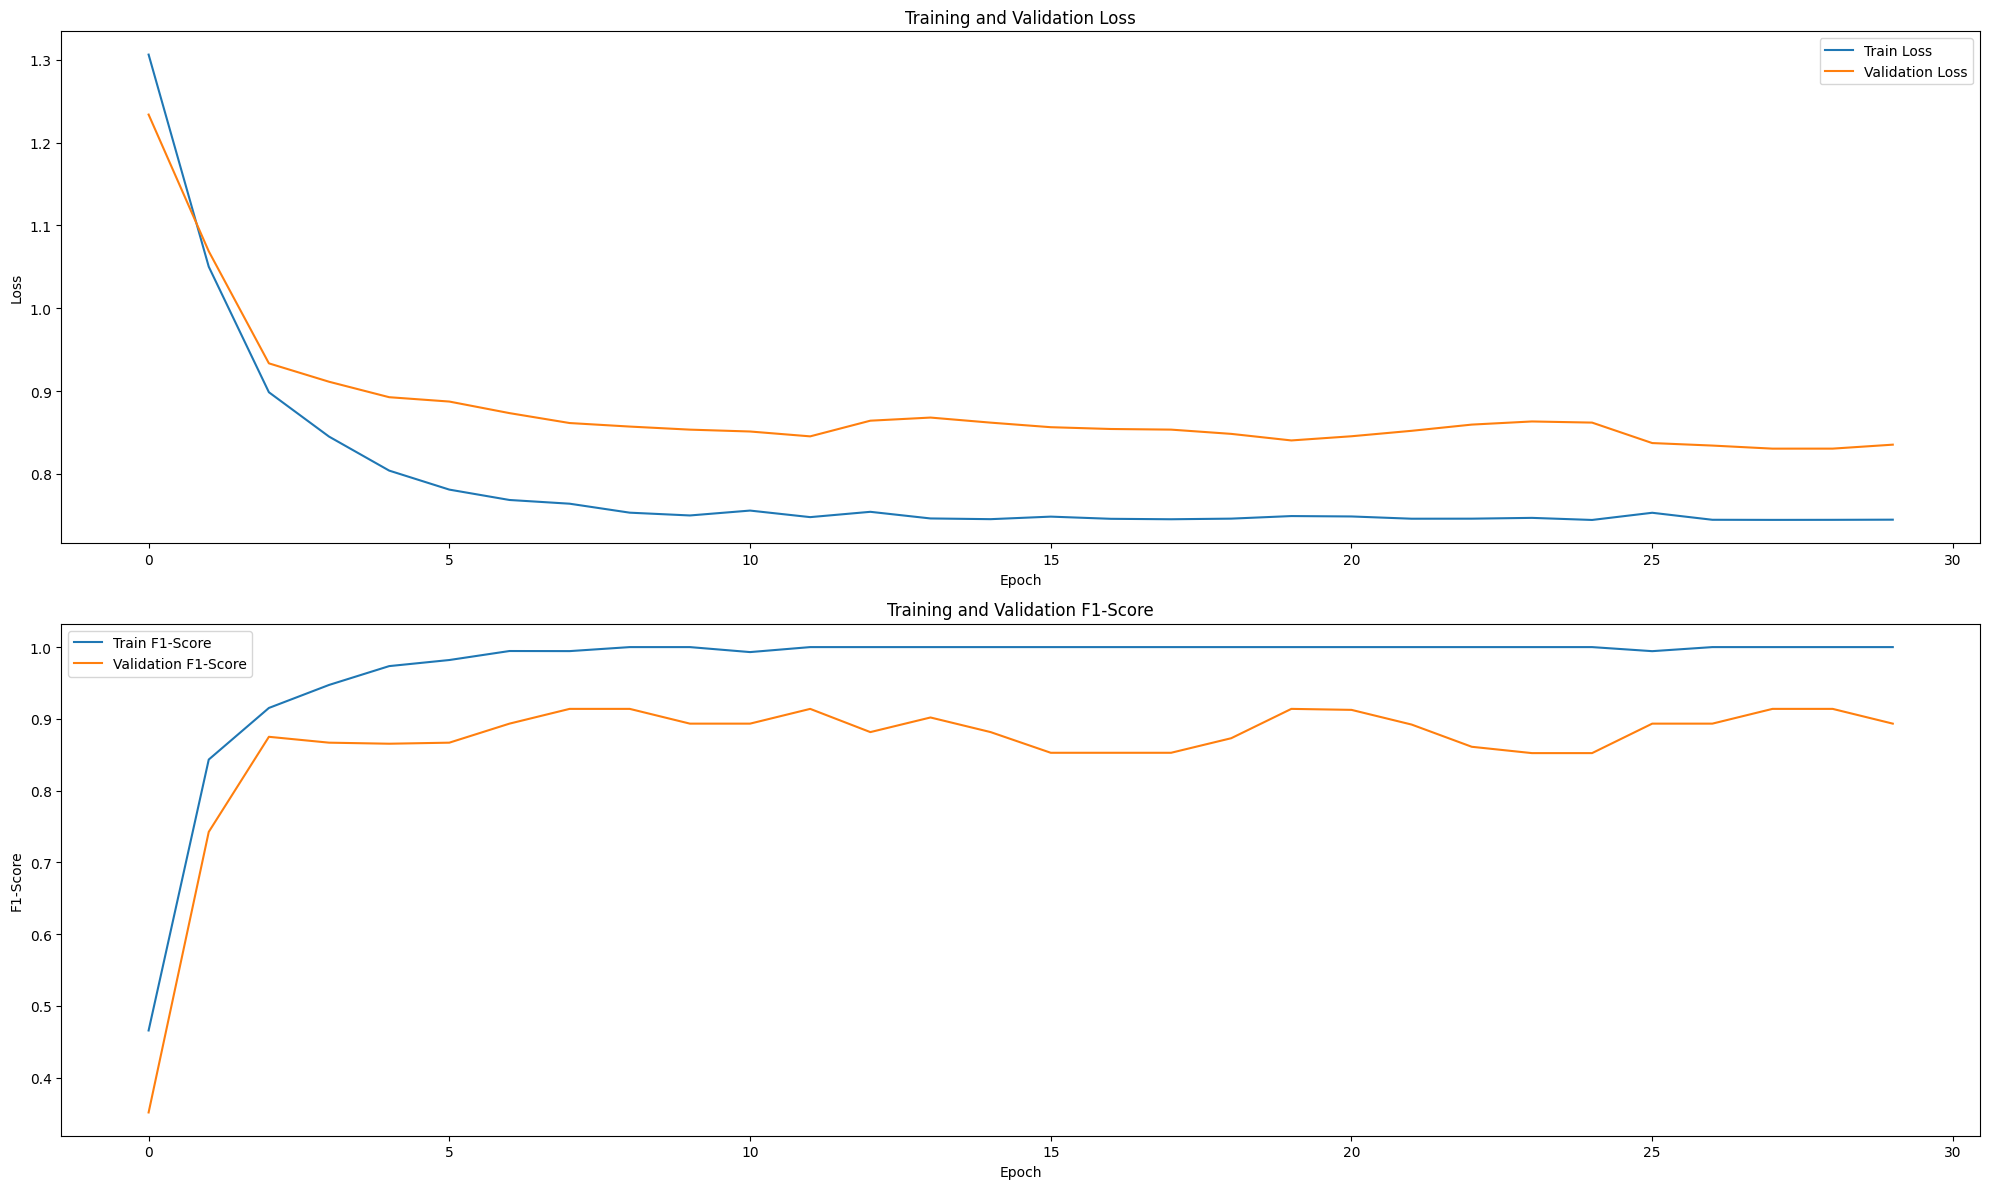

In [33]:
plot_training_results(history=history)

In [34]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9000, Precision: 0.9118, Recall: 0.8542, F1 Score: 0.8728
Classification Report : 

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       1.00      0.67      0.80         6
           2       0.79      0.92      0.85        12
           3       0.95      1.00      0.98        20

    accuracy                           0.90        50
   macro avg       0.91      0.85      0.87        50
weighted avg       0.91      0.90      0.90        50



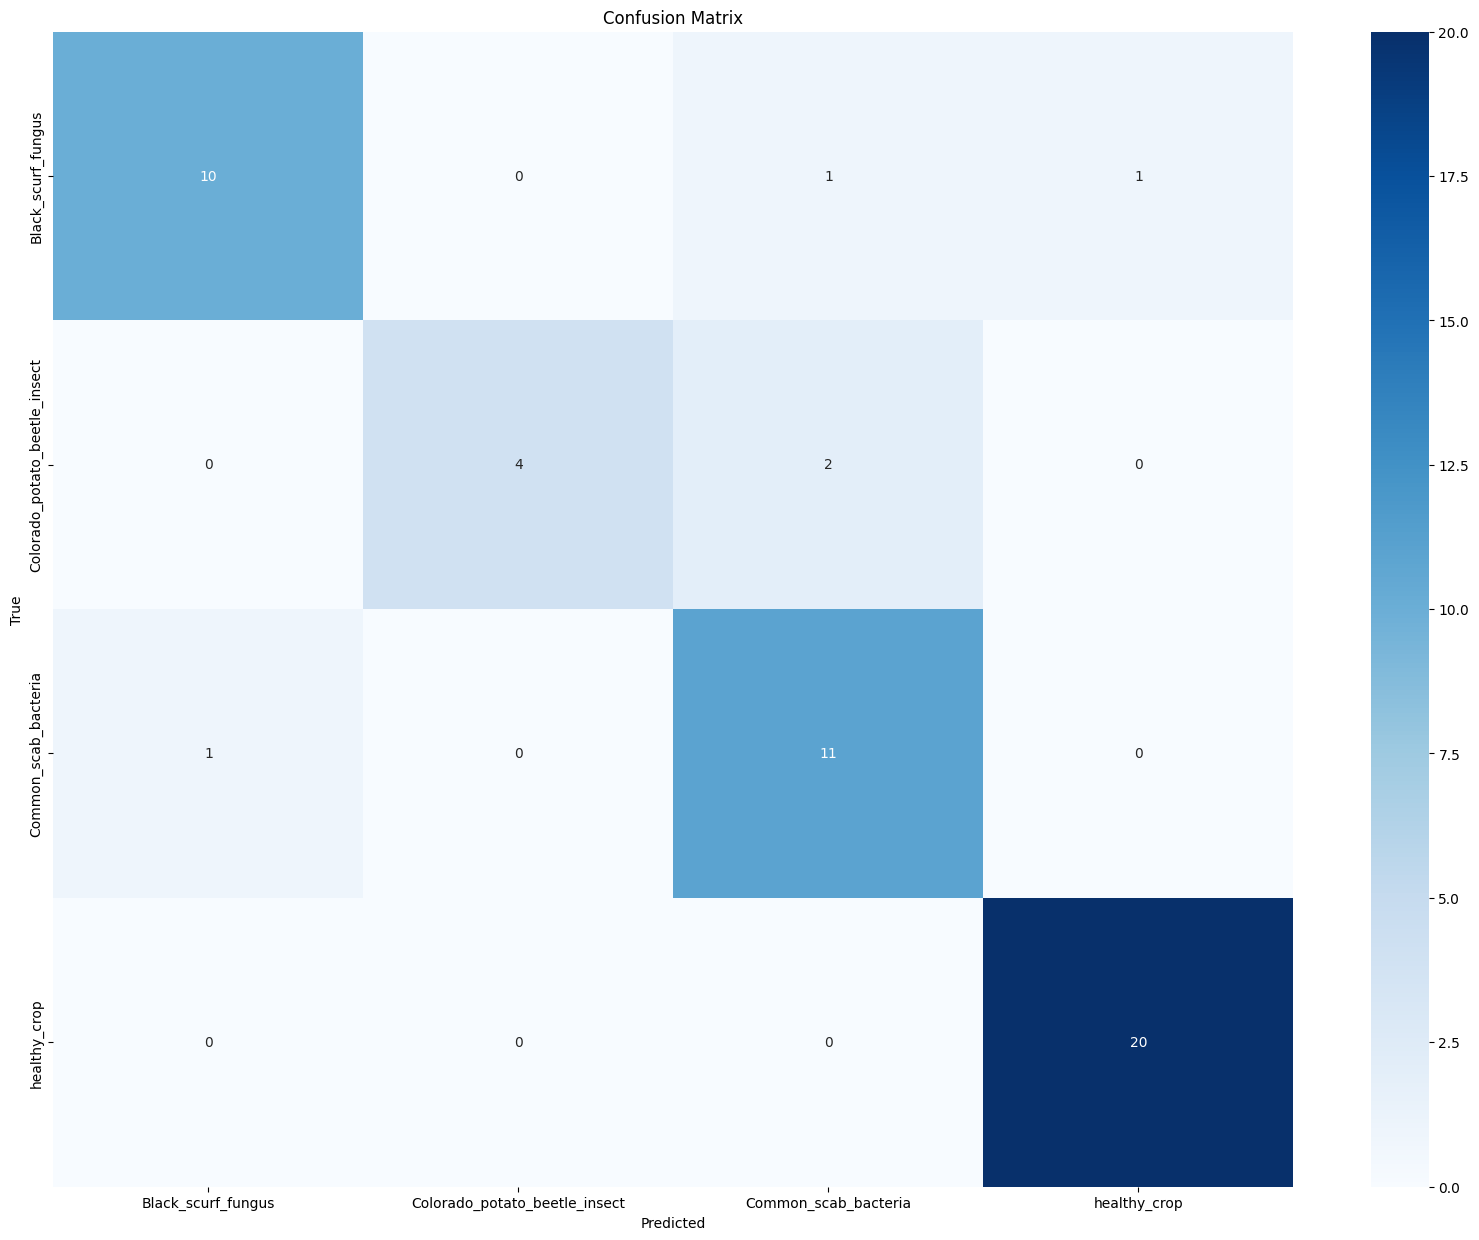

In [35]:
# plot confusion matrix
plot_cm(cm, class_names, title="Confusion Matrix")

###### With Augmentation

In [36]:
# tweak these and experiment with different values.
config = dict(
    resize =256 ,
    crop = 240,
    augment = True,
    epochs = 30,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'resnet50_weights_aug.pth'
)

In [37]:
# Define paths
ROOT_DIR = 'cleaned-p'

# Get transformations (without augmentation)
# train_transform, val_transform =  get_transforms(augment=False)
train_transform, valid_transform = get_transforms(augment=config['augment'])

# Load datasets
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation', resize=config['resize'], transform=valid_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test', resize=config['resize'], transform=valid_transform)

# number of workers
nw = min([os.cpu_count(), config['batch_size'] if config['batch_size'] > 1 else 0, 8])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=nw)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)

In [38]:
# Class names
class_names = train_dataset.class_names
class_dict = train_dataset.class_idx_to_name

In [39]:
# Initialize the model with best available pre-trained weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze the pre-trained model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(config['dropout']),
    nn.Linear(512, len(class_names)),
    nn.Softmax(dim=1)
)

# Set up the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the specified device
model = model.to(device)

# Define optimizer and loss funtion
optimizer = optim.Adam(params=model.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

In [40]:
# train and validate model performance
history = training_pipeline(
    config=config,
    model = model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stopping=None,
    device=device
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
----------
Train - Loss: 1.3247, Accuracy: 0.4570, Precision: 0.3239, Recall: 0.3559, F1 Score: 0.3172


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 1/30 [00:02<01:07,  2.32s/it]

Validation - Loss: 1.2556, Accuracy: 0.4200, Precision: 0.3564, Recall: 0.2917, F1 Score: 0.2207
Best model state saved
Epoch 2/30
----------
Train - Loss: 1.1154, Accuracy: 0.7152, Precision: 0.7503, Recall: 0.6372, F1 Score: 0.6508


  7%|▋         | 2/30 [00:05<01:13,  2.61s/it]

Validation - Loss: 1.1400, Accuracy: 0.5600, Precision: 0.6316, Recall: 0.5041, F1 Score: 0.4940
Best model state saved
Epoch 3/30
----------
Train - Loss: 0.9762, Accuracy: 0.8543, Precision: 0.8732, Recall: 0.8505, F1 Score: 0.8487


 10%|█         | 3/30 [00:08<01:19,  2.94s/it]

Validation - Loss: 1.0048, Accuracy: 0.7400, Precision: 0.7954, Recall: 0.7066, F1 Score: 0.7293
Best model state saved
Epoch 4/30
----------
Train - Loss: 0.9109, Accuracy: 0.9073, Precision: 0.8951, Recall: 0.9168, F1 Score: 0.9045


 13%|█▎        | 4/30 [00:10<01:09,  2.69s/it]

Validation - Loss: 0.9473, Accuracy: 0.7800, Precision: 0.8125, Recall: 0.7850, F1 Score: 0.7495
Best model state saved
Epoch 5/30
----------
Train - Loss: 0.8595, Accuracy: 0.9205, Precision: 0.9260, Recall: 0.9235, F1 Score: 0.9199


 17%|█▋        | 5/30 [00:13<01:03,  2.55s/it]

Validation - Loss: 0.9339, Accuracy: 0.8400, Precision: 0.8631, Recall: 0.8202, F1 Score: 0.8230
Best model state saved
Epoch 6/30
----------
Train - Loss: 0.8179, Accuracy: 0.9603, Precision: 0.9591, Recall: 0.9613, F1 Score: 0.9600


 20%|██        | 6/30 [00:15<00:59,  2.47s/it]

Validation - Loss: 0.9056, Accuracy: 0.8800, Precision: 0.8885, Recall: 0.8619, F1 Score: 0.8730
Best model state saved
Epoch 7/30
----------
Train - Loss: 0.8139, Accuracy: 0.9404, Precision: 0.9478, Recall: 0.9422, F1 Score: 0.9427


 23%|██▎       | 7/30 [00:17<00:56,  2.44s/it]

Validation - Loss: 0.9198, Accuracy: 0.8200, Precision: 0.8382, Recall: 0.8077, F1 Score: 0.8090
Best model state saved
Epoch 8/30
----------
Train - Loss: 0.7989, Accuracy: 0.9801, Precision: 0.9803, Recall: 0.9824, F1 Score: 0.9807


 27%|██▋       | 8/30 [00:21<00:59,  2.71s/it]

Validation - Loss: 0.8988, Accuracy: 0.8400, Precision: 0.8542, Recall: 0.8270, F1 Score: 0.8310
Best model state saved
Epoch 9/30
----------
Train - Loss: 0.7878, Accuracy: 0.9735, Precision: 0.9730, Recall: 0.9783, F1 Score: 0.9754


 30%|███       | 9/30 [00:24<00:58,  2.79s/it]

Validation - Loss: 0.8808, Accuracy: 0.8600, Precision: 0.8667, Recall: 0.8686, F1 Score: 0.8598
Best model state saved
Epoch 10/30
----------
Train - Loss: 0.7758, Accuracy: 0.9801, Precision: 0.9799, Recall: 0.9850, F1 Score: 0.9823


 33%|███▎      | 10/30 [00:26<00:52,  2.63s/it]

Validation - Loss: 0.8849, Accuracy: 0.8400, Precision: 0.8542, Recall: 0.8270, F1 Score: 0.8310
Best model state saved
Epoch 11/30
----------
Train - Loss: 0.7833, Accuracy: 0.9735, Precision: 0.9752, Recall: 0.9779, F1 Score: 0.9765


 37%|███▋      | 11/30 [00:28<00:47,  2.53s/it]

Validation - Loss: 0.9073, Accuracy: 0.8200, Precision: 0.8382, Recall: 0.8077, F1 Score: 0.8090
Best model state saved
Epoch 12/30
----------
Train - Loss: 0.7934, Accuracy: 0.9536, Precision: 0.9546, Recall: 0.9546, F1 Score: 0.9542


 40%|████      | 12/30 [00:30<00:44,  2.45s/it]

Validation - Loss: 0.9066, Accuracy: 0.8000, Precision: 0.8221, Recall: 0.7885, F1 Score: 0.7862
Best model state saved
Epoch 13/30
----------
Train - Loss: 0.7817, Accuracy: 0.9603, Precision: 0.9667, Recall: 0.9613, F1 Score: 0.9638


 43%|████▎     | 13/30 [00:33<00:43,  2.54s/it]

Validation - Loss: 0.8842, Accuracy: 0.8800, Precision: 0.8881, Recall: 0.8654, F1 Score: 0.8731
Best model state saved
Epoch 14/30
----------
Train - Loss: 0.7735, Accuracy: 0.9735, Precision: 0.9734, Recall: 0.9749, F1 Score: 0.9739


 47%|████▋     | 14/30 [00:36<00:44,  2.77s/it]

Validation - Loss: 0.8847, Accuracy: 0.8400, Precision: 0.8542, Recall: 0.8270, F1 Score: 0.8310
Best model state saved
Epoch 15/30
----------
Train - Loss: 0.7648, Accuracy: 0.9934, Precision: 0.9931, Recall: 0.9959, F1 Score: 0.9944


 50%|█████     | 15/30 [00:39<00:39,  2.63s/it]

Validation - Loss: 0.8911, Accuracy: 0.8400, Precision: 0.8542, Recall: 0.8270, F1 Score: 0.8310
Best model state saved
Epoch 16/30
----------
Train - Loss: 0.7597, Accuracy: 0.9868, Precision: 0.9865, Recall: 0.9891, F1 Score: 0.9876


 53%|█████▎    | 16/30 [00:41<00:35,  2.52s/it]

Validation - Loss: 0.8672, Accuracy: 0.8800, Precision: 0.8885, Recall: 0.8619, F1 Score: 0.8730
Best model state saved
Epoch 17/30
----------
Train - Loss: 0.7779, Accuracy: 0.9801, Precision: 0.9854, Recall: 0.9816, F1 Score: 0.9832


 57%|█████▋    | 17/30 [00:43<00:31,  2.44s/it]

Validation - Loss: 0.8783, Accuracy: 0.9000, Precision: 0.9074, Recall: 0.8846, F1 Score: 0.8937
Best model state saved
Epoch 18/30
----------
Train - Loss: 0.7593, Accuracy: 0.9868, Precision: 0.9865, Recall: 0.9865, F1 Score: 0.9861


 60%|██████    | 18/30 [00:46<00:28,  2.40s/it]

Validation - Loss: 0.9030, Accuracy: 0.8200, Precision: 0.8382, Recall: 0.8077, F1 Score: 0.8090
Best model state saved
Epoch 19/30
----------
Train - Loss: 0.7837, Accuracy: 0.9669, Precision: 0.9722, Recall: 0.9689, F1 Score: 0.9693


 63%|██████▎   | 19/30 [00:49<00:29,  2.65s/it]

Validation - Loss: 0.8740, Accuracy: 0.8800, Precision: 0.8885, Recall: 0.8619, F1 Score: 0.8730
Best model state saved
Epoch 20/30
----------
Train - Loss: 0.7554, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 67%|██████▋   | 20/30 [00:51<00:26,  2.63s/it]

Validation - Loss: 0.8665, Accuracy: 0.8800, Precision: 0.8885, Recall: 0.8619, F1 Score: 0.8730
Best model state saved
Epoch 21/30
----------
Train - Loss: 0.7584, Accuracy: 0.9868, Precision: 0.9893, Recall: 0.9888, F1 Score: 0.9889


 70%|███████   | 21/30 [00:54<00:23,  2.56s/it]

Validation - Loss: 0.8770, Accuracy: 0.8600, Precision: 0.8706, Recall: 0.8462, F1 Score: 0.8523
Best model state saved
Epoch 22/30
----------
Train - Loss: 0.7546, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 73%|███████▎  | 22/30 [00:56<00:19,  2.49s/it]

Validation - Loss: 0.8655, Accuracy: 0.9000, Precision: 0.9074, Recall: 0.8846, F1 Score: 0.8937
Best model state saved
Epoch 23/30
----------
Train - Loss: 0.7559, Accuracy: 0.9934, Precision: 0.9934, Recall: 0.9929, F1 Score: 0.9930


 77%|███████▋  | 23/30 [00:58<00:16,  2.42s/it]

Validation - Loss: 0.8607, Accuracy: 0.9000, Precision: 0.9125, Recall: 0.8811, F1 Score: 0.8933
Best model state saved
Epoch 24/30
----------
Train - Loss: 0.7600, Accuracy: 0.9934, Precision: 0.9960, Recall: 0.9929, F1 Score: 0.9943


 80%|████████  | 24/30 [01:01<00:14,  2.49s/it]

Validation - Loss: 0.8773, Accuracy: 0.8600, Precision: 0.8799, Recall: 0.8360, F1 Score: 0.8511
Best model state saved
Epoch 25/30
----------
Train - Loss: 0.7567, Accuracy: 0.9868, Precision: 0.9890, Recall: 0.9865, F1 Score: 0.9875


 83%|████████▎ | 25/30 [01:04<00:13,  2.75s/it]

Validation - Loss: 0.8464, Accuracy: 0.9000, Precision: 0.9125, Recall: 0.8811, F1 Score: 0.8933
Best model state saved
Epoch 26/30
----------
Train - Loss: 0.7556, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 87%|████████▋ | 26/30 [01:07<00:10,  2.63s/it]

Validation - Loss: 0.8387, Accuracy: 0.9000, Precision: 0.9097, Recall: 0.9001, F1 Score: 0.9005
Best model state saved
Epoch 27/30
----------
Train - Loss: 0.7492, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 90%|█████████ | 27/30 [01:09<00:07,  2.54s/it]

Validation - Loss: 0.8428, Accuracy: 0.9200, Precision: 0.9250, Recall: 0.9228, F1 Score: 0.9222
Best model state saved
Epoch 28/30
----------
Train - Loss: 0.7643, Accuracy: 0.9868, Precision: 0.9865, Recall: 0.9865, F1 Score: 0.9861


 93%|█████████▎| 28/30 [01:11<00:04,  2.47s/it]

Validation - Loss: 0.8516, Accuracy: 0.9000, Precision: 0.9006, Recall: 0.9071, F1 Score: 0.9019
Best model state saved
Epoch 29/30
----------
Train - Loss: 0.7532, Accuracy: 0.9934, Precision: 0.9931, Recall: 0.9932, F1 Score: 0.9931


 97%|█████████▋| 29/30 [01:14<00:02,  2.41s/it]

Validation - Loss: 0.8435, Accuracy: 0.9200, Precision: 0.9412, Recall: 0.9193, F1 Score: 0.9208
Best model state saved
Epoch 30/30
----------
Train - Loss: 0.7622, Accuracy: 0.9868, Precision: 0.9861, Recall: 0.9861, F1 Score: 0.9861


100%|██████████| 30/30 [01:17<00:00,  2.58s/it]

Validation - Loss: 0.8695, Accuracy: 0.8600, Precision: 0.8708, Recall: 0.8392, F1 Score: 0.8517
Best model state saved


Best model saved in artifacts folder


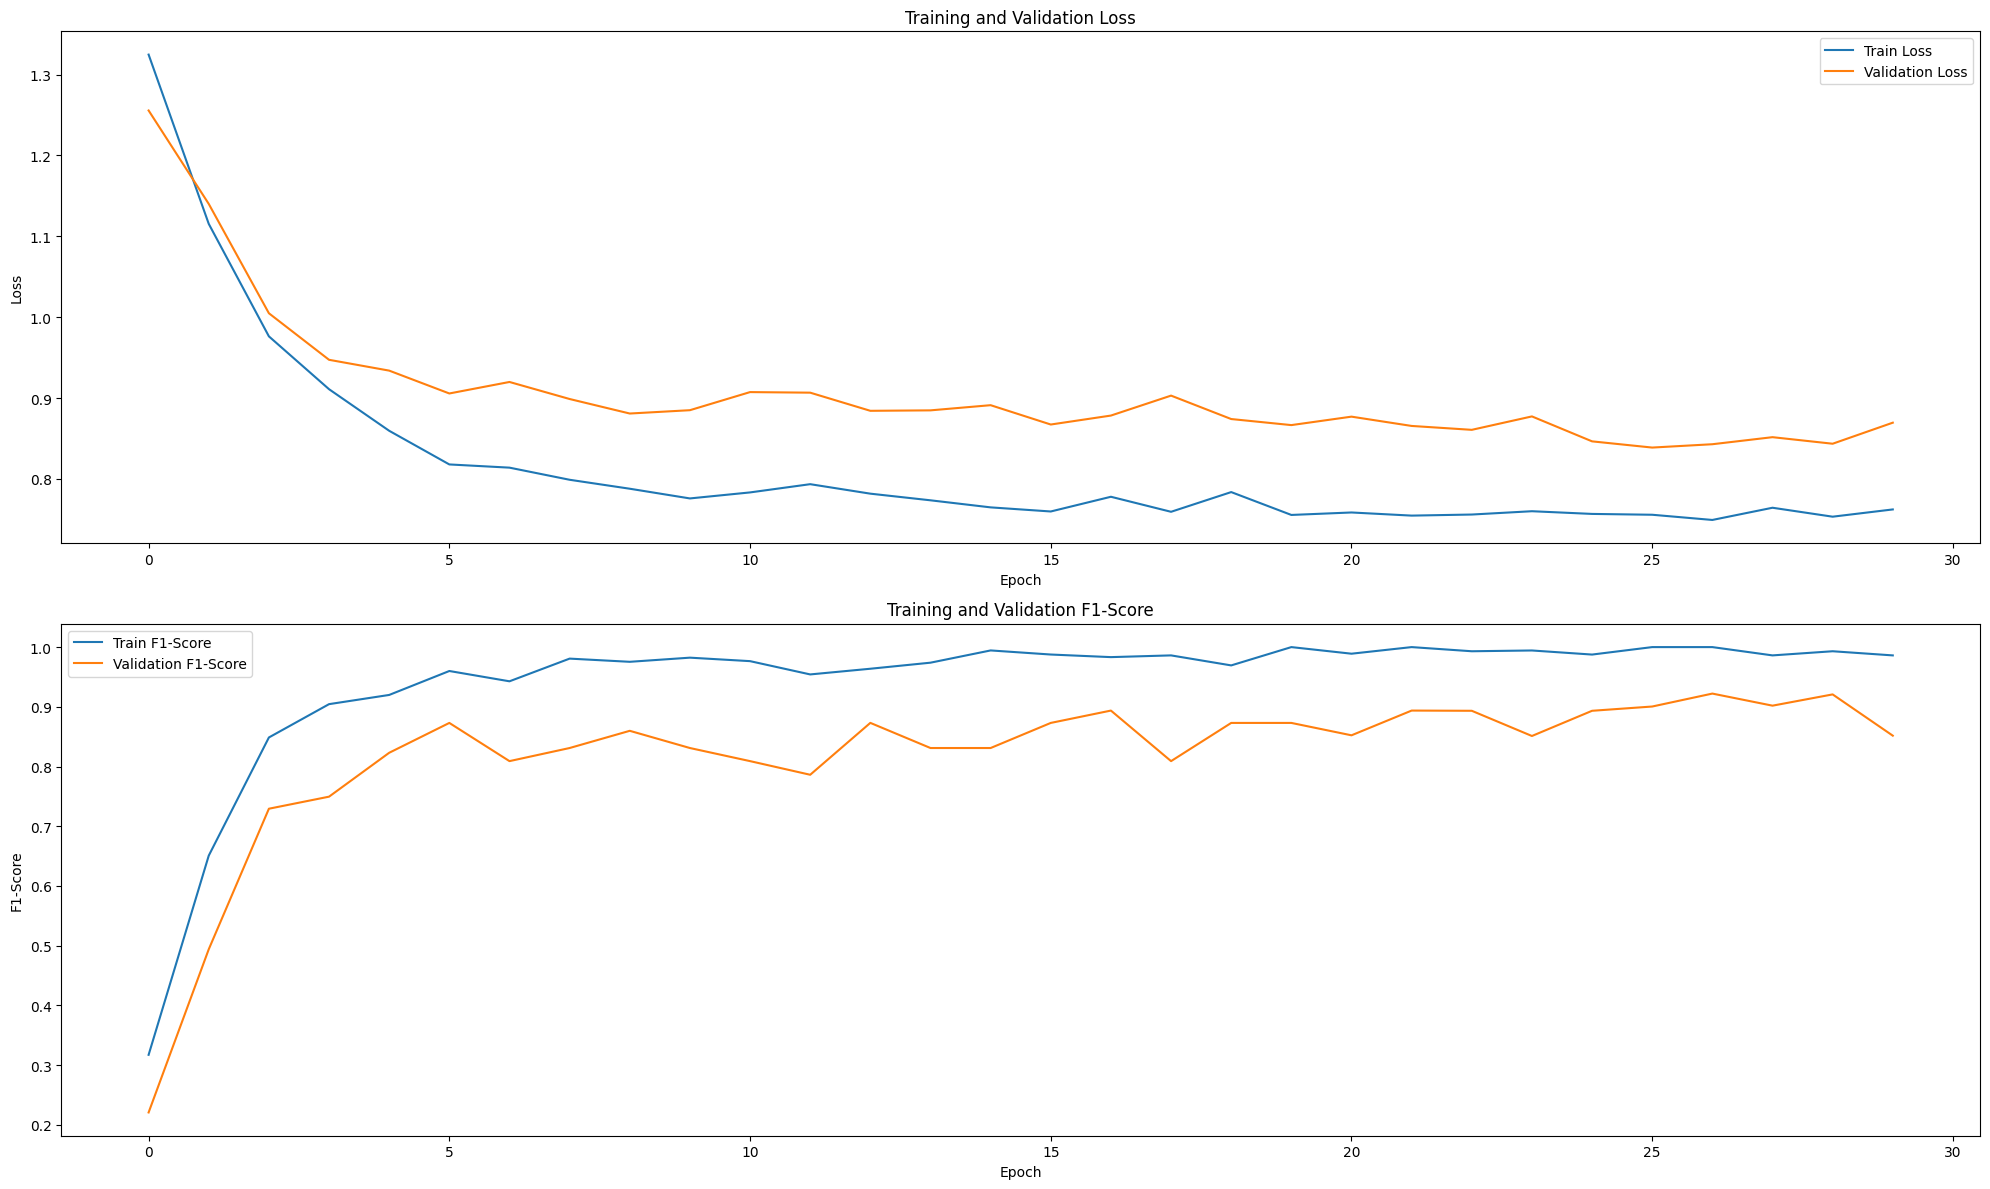

In [41]:
plot_training_results(history=history)

In [42]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9200, Precision: 0.9022, Recall: 0.8958, F1 Score: 0.8968
Classification Report : 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.83      0.83      0.83         6
           2       0.90      0.75      0.82        12
           3       0.95      1.00      0.98        20

    accuracy                           0.92        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.92      0.92      0.92        50



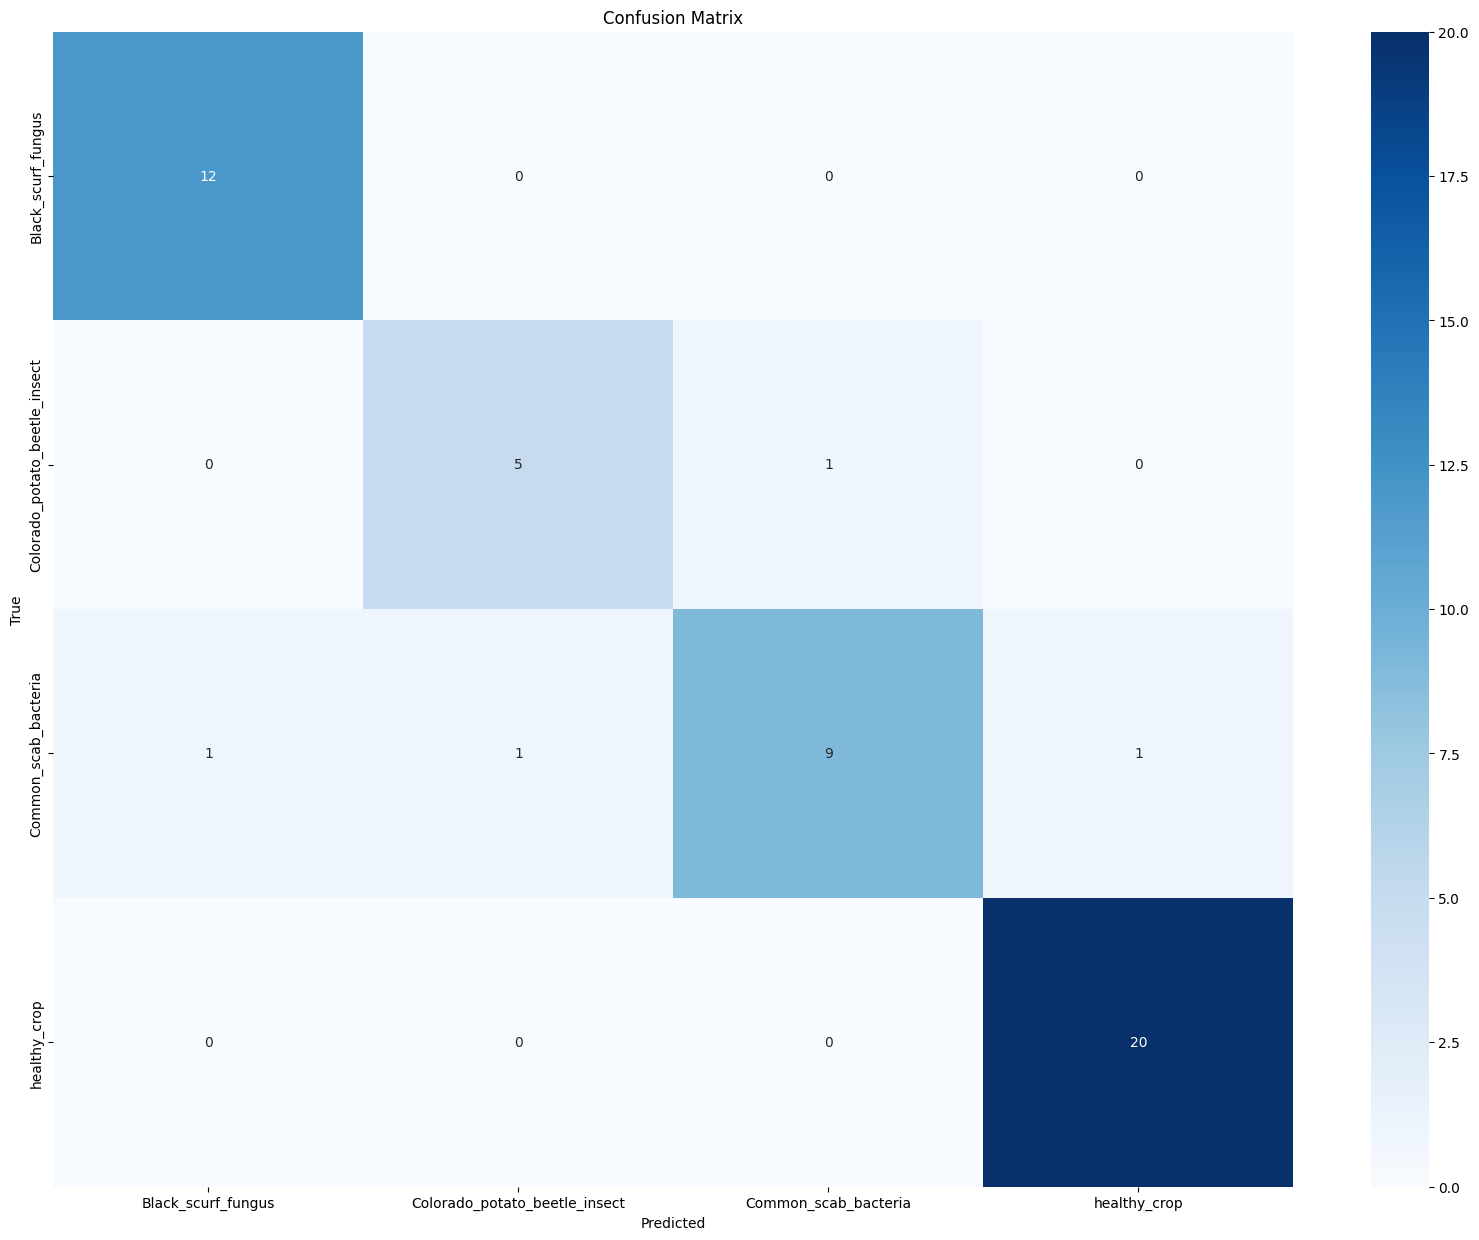

In [43]:
# plot confusion matrix
plot_cm(cm, class_names, title="Confusion Matrix")

### Modeling EfficientNet

###### Without Augmentation

In [55]:
# tweak these and experiment with different values.
config = dict(
    resize =256 ,
    crop = 240,
    augment= False,
    epochs = 30,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'efficientnet_b0_weights_basic.pth'
)

In [56]:
# Define paths
train_dir = 'cleaned-p/train'
valid_dir = 'cleaned-p/validation'
test_dir = 'cleaned-p/test'
ROOT_DIR = 'cleaned-p'

# Get transformations (without augmentation)
train_transform, valid_transform = get_transforms(augment=config['augment'])

# Load datasets
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation', resize=config['resize'], transform=valid_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test', resize=config['resize'], transform=valid_transform)

# number of workers
nw = min([os.cpu_count(), config['batch_size'] if config['batch_size'] > 1 else 0, 8])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=nw)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)

In [57]:
print(train_transform)

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [58]:
print(nw)

2


In [59]:
print(train_dataset.class_idx_to_name)

{0: 'Black_scurf_fungus', 1: 'Colorado_potato_beetle_insect', 2: 'Common_scab_bacteria', 3: 'healthy_crop'}


In [60]:
# Class names
class_names = train_dataset.class_names
class_dict = train_dataset.class_idx_to_name

In [61]:
# Initialize the model with best available pre-trained weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

# Freeze the pre-trained model parameters
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[1].in_features

# Modify the last fully connected layer
model.classifier = nn.Sequential(
    nn.Dropout(config['dropout']),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(config['dropout']),
    nn.Linear(512, len(class_names)),
    nn.Softmax(dim=1)
)

# Set up the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the specified device
model = model.to(device)

# Define optimizer and loss funtion
optimizer = optim.Adam(params=model.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

In [62]:
# train and validate model performance
history = training_pipeline(
    config=config,
    model = model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stopping=None,
    device=device
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
----------
Train - Loss: 1.2996, Accuracy: 0.5099, Precision: 0.4790, Recall: 0.4304, F1 Score: 0.4276
Validation - Loss: 1.1906, Accuracy: 0.5800, Precision: 0.7851, Recall: 0.4525, F1 Score: 0.4542


  3%|▎         | 1/30 [00:02<01:07,  2.34s/it]

Best model state saved
Epoch 2/30
----------
Train - Loss: 1.0426, Accuracy: 0.8675, Precision: 0.8874, Recall: 0.8670, F1 Score: 0.8611


  7%|▋         | 2/30 [00:05<01:11,  2.54s/it]

Validation - Loss: 1.0461, Accuracy: 0.7800, Precision: 0.8583, Recall: 0.7366, F1 Score: 0.7582
Best model state saved
Epoch 3/30
----------
Train - Loss: 0.9009, Accuracy: 0.9338, Precision: 0.9291, Recall: 0.9370, F1 Score: 0.9314


 10%|█         | 3/30 [00:07<01:02,  2.33s/it]

Validation - Loss: 0.9378, Accuracy: 0.8800, Precision: 0.9100, Recall: 0.8846, F1 Score: 0.8726
Best model state saved
Epoch 4/30
----------
Train - Loss: 0.8608, Accuracy: 0.9272, Precision: 0.9285, Recall: 0.9352, F1 Score: 0.9312


 13%|█▎        | 4/30 [00:09<00:56,  2.18s/it]

Validation - Loss: 0.9005, Accuracy: 0.8600, Precision: 0.8604, Recall: 0.8616, F1 Score: 0.8606
Best model state saved
Epoch 5/30
----------
Train - Loss: 0.8204, Accuracy: 0.9404, Precision: 0.9335, Recall: 0.9456, F1 Score: 0.9389


 17%|█▋        | 5/30 [00:11<00:57,  2.31s/it]

Validation - Loss: 0.9075, Accuracy: 0.8600, Precision: 0.8657, Recall: 0.8360, F1 Score: 0.8462
Best model state saved
Epoch 6/30
----------
Train - Loss: 0.8051, Accuracy: 0.9669, Precision: 0.9542, Recall: 0.9711, F1 Score: 0.9618


 20%|██        | 6/30 [00:14<00:57,  2.40s/it]

Validation - Loss: 0.9236, Accuracy: 0.8200, Precision: 0.8325, Recall: 0.7975, F1 Score: 0.8033
Best model state saved
Epoch 7/30
----------
Train - Loss: 0.7911, Accuracy: 0.9735, Precision: 0.9752, Recall: 0.9779, F1 Score: 0.9765


 23%|██▎       | 7/30 [00:16<00:52,  2.29s/it]

Validation - Loss: 0.9201, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 8/30
----------
Train - Loss: 0.7915, Accuracy: 0.9669, Precision: 0.9702, Recall: 0.9734, F1 Score: 0.9705


 27%|██▋       | 8/30 [00:18<00:52,  2.36s/it]

Validation - Loss: 0.9233, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 9/30
----------
Train - Loss: 0.7790, Accuracy: 0.9735, Precision: 0.9666, Recall: 0.9809, F1 Score: 0.9732


 30%|███       | 9/30 [00:20<00:47,  2.25s/it]

Validation - Loss: 0.9224, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 10/30
----------
Train - Loss: 0.7795, Accuracy: 0.9669, Precision: 0.9594, Recall: 0.9708, F1 Score: 0.9648


 33%|███▎      | 10/30 [00:22<00:41,  2.09s/it]

Validation - Loss: 0.9208, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 11/30
----------
Train - Loss: 0.7601, Accuracy: 0.9934, Precision: 0.9931, Recall: 0.9959, F1 Score: 0.9944


 37%|███▋      | 11/30 [00:24<00:37,  1.97s/it]

Validation - Loss: 0.9226, Accuracy: 0.8200, Precision: 0.8300, Recall: 0.8042, F1 Score: 0.8114
Best model state saved
Epoch 12/30
----------
Train - Loss: 0.8252, Accuracy: 0.9404, Precision: 0.9587, Recall: 0.9403, F1 Score: 0.9480


 40%|████      | 12/30 [00:25<00:34,  1.90s/it]

Validation - Loss: 0.9202, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 13/30
----------
Train - Loss: 0.7627, Accuracy: 0.9801, Precision: 0.9812, Recall: 0.9816, F1 Score: 0.9808


 43%|████▎     | 13/30 [00:27<00:31,  1.86s/it]

Validation - Loss: 0.9089, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 14/30
----------
Train - Loss: 0.7622, Accuracy: 0.9868, Precision: 0.9865, Recall: 0.9918, F1 Score: 0.9890


 47%|████▋     | 14/30 [00:29<00:29,  1.84s/it]

Validation - Loss: 0.9088, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 15/30
----------
Train - Loss: 0.7729, Accuracy: 0.9801, Precision: 0.9731, Recall: 0.9850, F1 Score: 0.9788


 50%|█████     | 15/30 [00:32<00:31,  2.07s/it]

Validation - Loss: 0.9096, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 16/30
----------
Train - Loss: 0.7560, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 53%|█████▎    | 16/30 [00:34<00:31,  2.28s/it]

Validation - Loss: 0.9238, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 17/30
----------
Train - Loss: 0.7549, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 57%|█████▋    | 17/30 [00:36<00:27,  2.12s/it]

Validation - Loss: 0.9354, Accuracy: 0.8200, Precision: 0.8311, Recall: 0.8042, F1 Score: 0.8131
Best model state saved
Epoch 18/30
----------
Train - Loss: 0.7587, Accuracy: 0.9934, Precision: 0.9960, Recall: 0.9932, F1 Score: 0.9945


 60%|██████    | 18/30 [00:38<00:23,  1.99s/it]

Validation - Loss: 0.9377, Accuracy: 0.8000, Precision: 0.8208, Recall: 0.7626, F1 Score: 0.7804
Best model state saved
Epoch 19/30
----------
Train - Loss: 0.7836, Accuracy: 0.9735, Precision: 0.9671, Recall: 0.9730, F1 Score: 0.9687


 63%|██████▎   | 19/30 [00:39<00:20,  1.90s/it]

Validation - Loss: 0.9334, Accuracy: 0.8200, Precision: 0.8300, Recall: 0.8042, F1 Score: 0.8114
Best model state saved
Epoch 20/30
----------
Train - Loss: 0.7505, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 67%|██████▋   | 20/30 [00:41<00:18,  1.86s/it]

Validation - Loss: 0.9277, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 21/30
----------
Train - Loss: 0.7578, Accuracy: 0.9934, Precision: 0.9931, Recall: 0.9959, F1 Score: 0.9944


 70%|███████   | 21/30 [00:43<00:16,  1.83s/it]

Validation - Loss: 0.9253, Accuracy: 0.8200, Precision: 0.8272, Recall: 0.8007, F1 Score: 0.8118
Best model state saved
Epoch 22/30
----------
Train - Loss: 0.7475, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 73%|███████▎  | 22/30 [00:45<00:15,  1.89s/it]

Validation - Loss: 0.9285, Accuracy: 0.8000, Precision: 0.8095, Recall: 0.7815, F1 Score: 0.7929
Best model state saved
Epoch 23/30
----------
Train - Loss: 0.7544, Accuracy: 0.9934, Precision: 0.9934, Recall: 0.9929, F1 Score: 0.9930


 77%|███████▋  | 23/30 [00:48<00:14,  2.10s/it]

Validation - Loss: 0.9306, Accuracy: 0.8000, Precision: 0.8208, Recall: 0.7626, F1 Score: 0.7804
Best model state saved
Epoch 24/30
----------
Train - Loss: 0.7484, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 80%|████████  | 24/30 [00:49<00:11,  2.00s/it]

Validation - Loss: 0.9313, Accuracy: 0.8000, Precision: 0.8208, Recall: 0.7626, F1 Score: 0.7804
Best model state saved
Epoch 25/30
----------
Train - Loss: 0.7553, Accuracy: 0.9934, Precision: 0.9934, Recall: 0.9959, F1 Score: 0.9946


 83%|████████▎ | 25/30 [00:51<00:09,  1.91s/it]

Validation - Loss: 0.9354, Accuracy: 0.8000, Precision: 0.8208, Recall: 0.7626, F1 Score: 0.7804
Best model state saved
Epoch 26/30
----------
Train - Loss: 0.7546, Accuracy: 0.9934, Precision: 0.9931, Recall: 0.9932, F1 Score: 0.9931


 87%|████████▋ | 26/30 [00:53<00:07,  1.86s/it]

Validation - Loss: 0.9381, Accuracy: 0.8000, Precision: 0.8208, Recall: 0.7626, F1 Score: 0.7804
Best model state saved
Epoch 27/30
----------
Train - Loss: 0.7554, Accuracy: 0.9934, Precision: 0.9934, Recall: 0.9929, F1 Score: 0.9930


 90%|█████████ | 27/30 [00:55<00:05,  1.82s/it]

Validation - Loss: 0.9365, Accuracy: 0.8000, Precision: 0.8208, Recall: 0.7626, F1 Score: 0.7804
Best model state saved
Epoch 28/30
----------
Train - Loss: 0.7510, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 93%|█████████▎| 28/30 [00:56<00:03,  1.79s/it]

Validation - Loss: 0.9323, Accuracy: 0.8000, Precision: 0.8208, Recall: 0.7626, F1 Score: 0.7804
Best model state saved
Epoch 29/30
----------
Train - Loss: 0.7491, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


 97%|█████████▋| 29/30 [00:58<00:01,  1.81s/it]

Validation - Loss: 0.9265, Accuracy: 0.8400, Precision: 0.8481, Recall: 0.8235, F1 Score: 0.8323
Best model state saved
Epoch 30/30
----------
Train - Loss: 0.7515, Accuracy: 0.9934, Precision: 0.9934, Recall: 0.9861, F1 Score: 0.9895


100%|██████████| 30/30 [01:01<00:00,  2.04s/it]

Validation - Loss: 0.9226, Accuracy: 0.8200, Precision: 0.8300, Recall: 0.8042, F1 Score: 0.8114
Best model state saved
Best model saved in artifacts folder


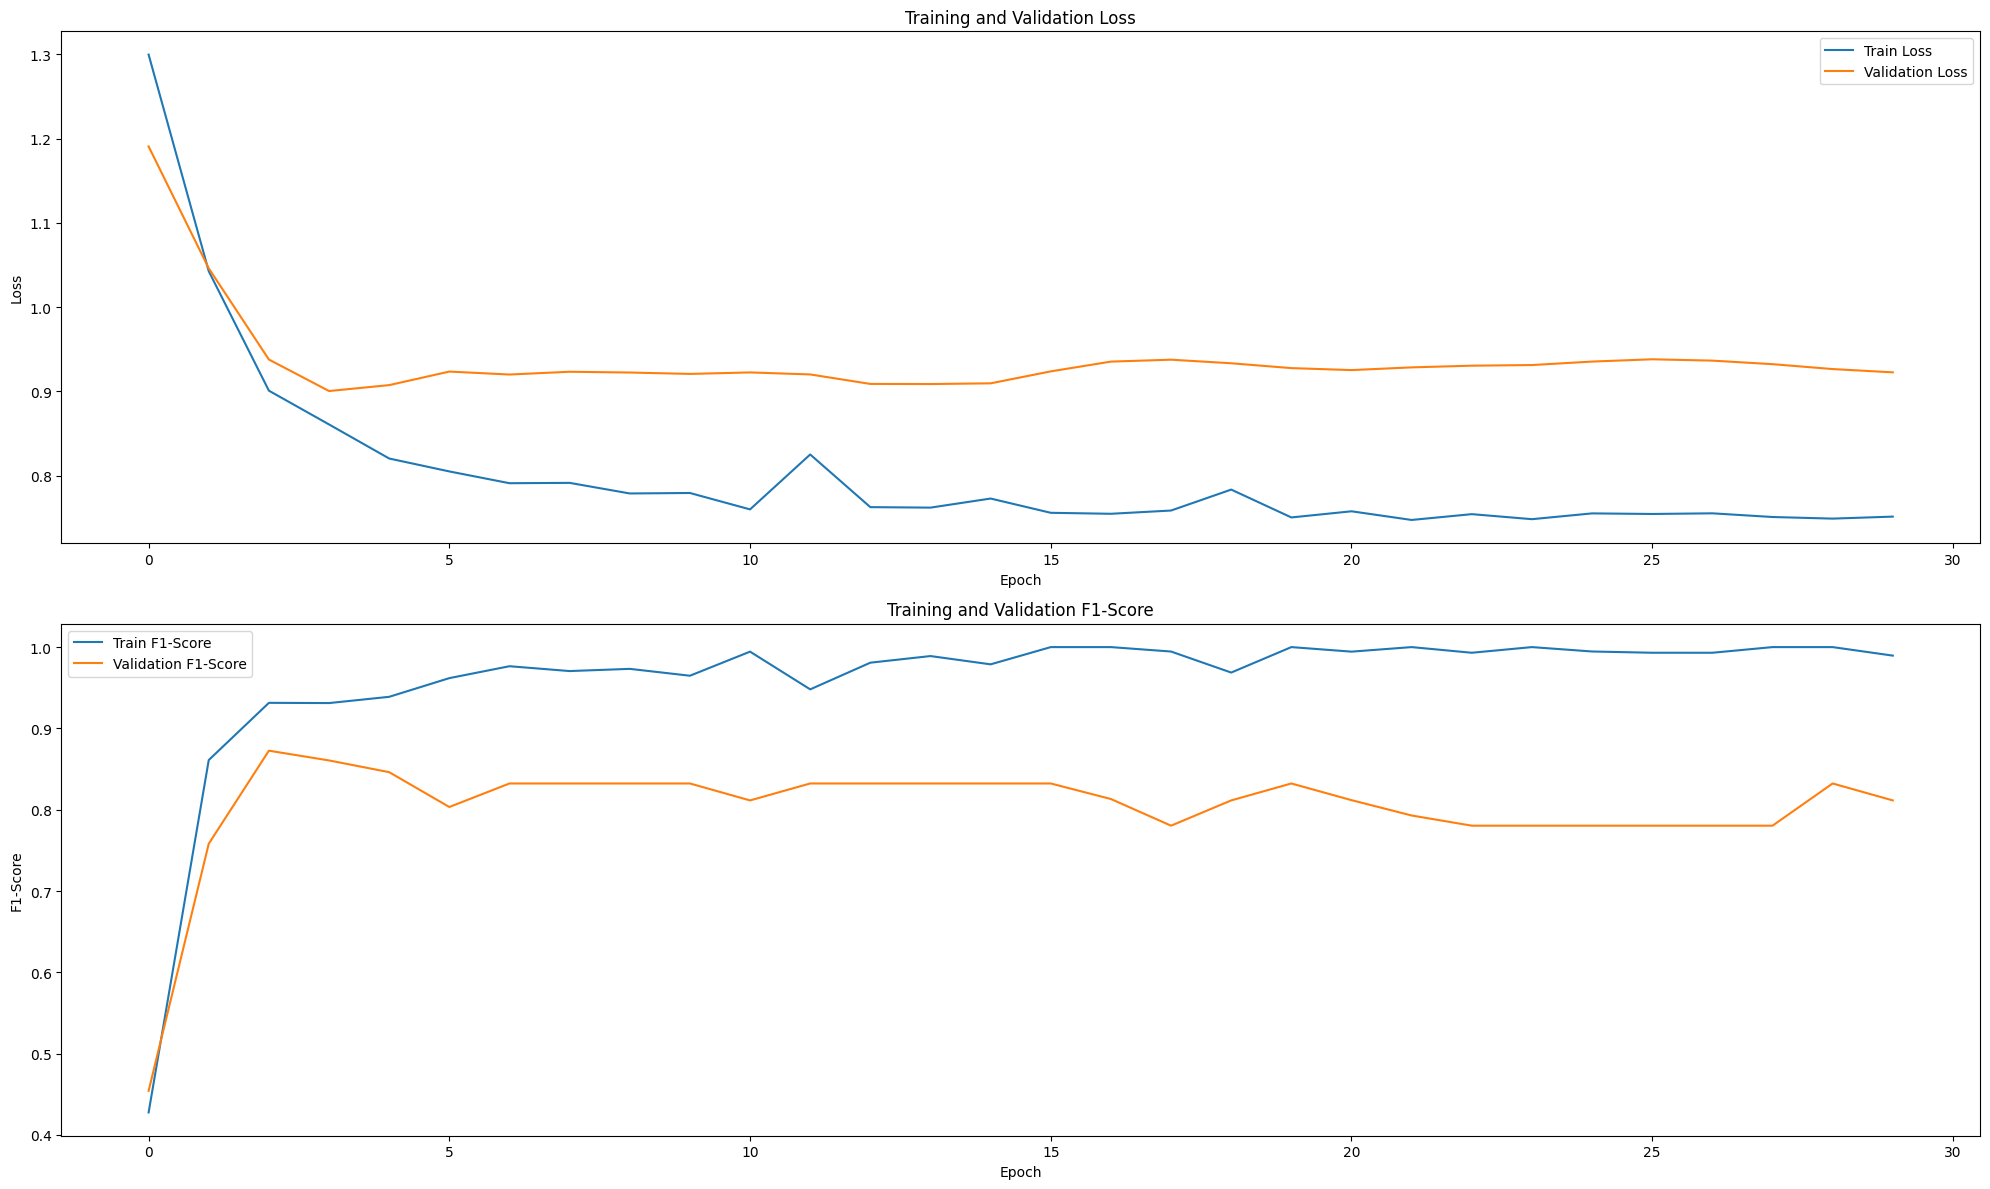

In [63]:
plot_training_results(history=history)

In [64]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.8600, Precision: 0.8794, Recall: 0.8333, F1 Score: 0.8441
Classification Report : 

              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       1.00      0.83      0.91         6
           2       0.88      0.58      0.70        12
           3       0.91      1.00      0.95        20

    accuracy                           0.86        50
   macro avg       0.88      0.83      0.84        50
weighted avg       0.87      0.86      0.85        50



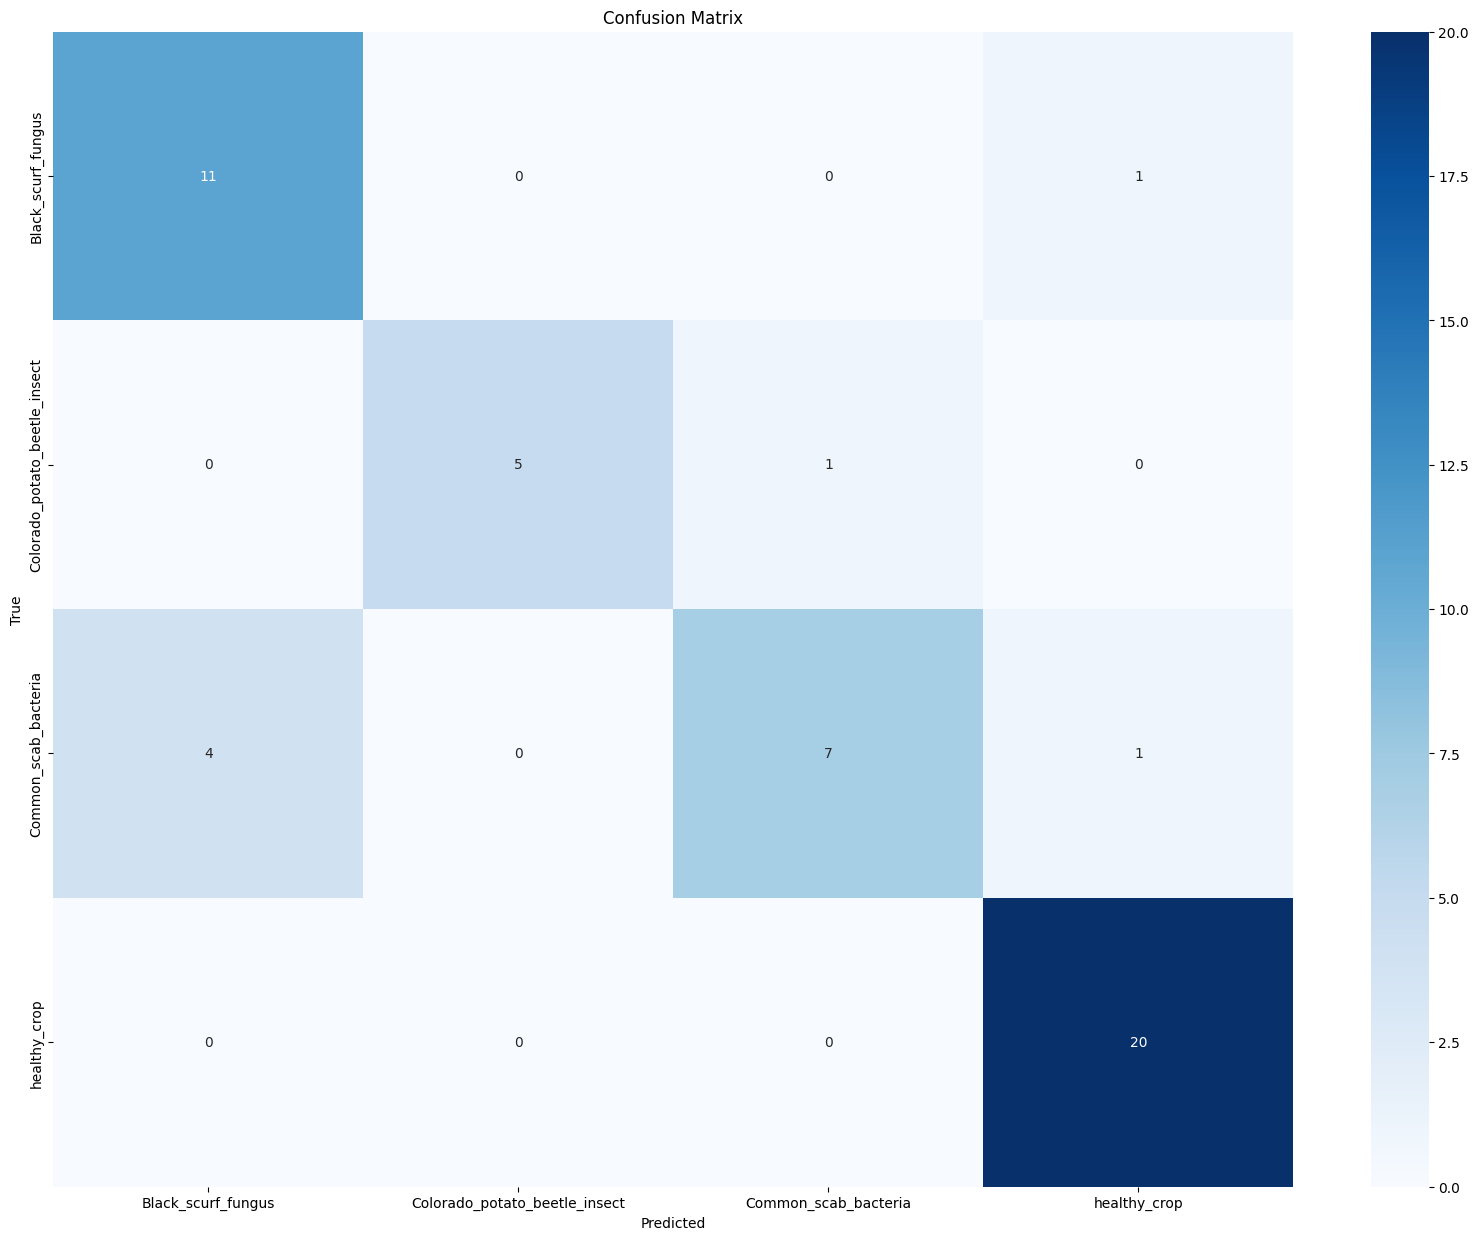

In [65]:
# plot confusion matrix
plot_cm(cm, class_names, title="Confusion Matrix")

###### With Augmentation

In [66]:
# tweak these and experiment with different values.
config = dict(
    resize =256 ,
    crop = 240,
    augment = True,
    epochs = 30,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'efficientnet_b0_weights_aug.pth'
)

In [67]:
# Define paths
ROOT_DIR = 'cleaned-p'

# Get transformations (without augmentation)
# train_transform, val_transform =  get_transforms(augment=False)
train_transform, valid_transform = get_transforms(augment=config['augment'])

# Load datasets
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation', resize=config['resize'], transform=valid_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test', resize=config['resize'], transform=valid_transform)

# number of workers
nw = min([os.cpu_count(), config['batch_size'] if config['batch_size'] > 1 else 0, 8])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=nw)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)

In [68]:
# Class names
class_names = train_dataset.class_names
class_dict = train_dataset.class_idx_to_name

In [69]:
# Initialize the model with best available pre-trained weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

# Freeze the pre-trained model parameters
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[1].in_features

# Modify the last fully connected layer
model.classifier = nn.Sequential(
    nn.Dropout(config['dropout']),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(config['dropout']),
    nn.Linear(512, len(class_names)),
    nn.Softmax(dim=1)
)

# Set up the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the specified device
model = model.to(device)

# Define optimizer and loss funtion
optimizer = optim.Adam(params=model.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

In [70]:
# train and validate model performance
history = training_pipeline(
    config=config,
    model = model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stopping=None,
    device=device
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
----------
Train - Loss: 1.3171, Accuracy: 0.4636, Precision: 0.3338, Recall: 0.3535, F1 Score: 0.3010


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 1/30 [00:02<01:03,  2.20s/it]

Validation - Loss: 1.2298, Accuracy: 0.4200, Precision: 0.3520, Recall: 0.2727, F1 Score: 0.1866
Best model state saved
Epoch 2/30
----------
Train - Loss: 1.1280, Accuracy: 0.6954, Precision: 0.7771, Recall: 0.5881, F1 Score: 0.6037


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 2/30 [00:04<01:00,  2.15s/it]

Validation - Loss: 1.0853, Accuracy: 0.6400, Precision: 0.5446, Recall: 0.5985, F1 Score: 0.5499
Best model state saved
Epoch 3/30
----------
Train - Loss: 0.9839, Accuracy: 0.9139, Precision: 0.9252, Recall: 0.9225, F1 Score: 0.9209


 10%|█         | 3/30 [00:06<00:57,  2.13s/it]

Validation - Loss: 0.9612, Accuracy: 0.8400, Precision: 0.8582, Recall: 0.8427, F1 Score: 0.8304
Best model state saved
Epoch 4/30
----------
Train - Loss: 0.9159, Accuracy: 0.8742, Precision: 0.8724, Recall: 0.8853, F1 Score: 0.8777


 13%|█▎        | 4/30 [00:08<00:58,  2.23s/it]

Validation - Loss: 0.9214, Accuracy: 0.8400, Precision: 0.8586, Recall: 0.8427, F1 Score: 0.8291
Best model state saved
Epoch 5/30
----------
Train - Loss: 0.8827, Accuracy: 0.9007, Precision: 0.8891, Recall: 0.9070, F1 Score: 0.8970


 17%|█▋        | 5/30 [00:12<01:04,  2.59s/it]

Validation - Loss: 0.9067, Accuracy: 0.8800, Precision: 0.8946, Recall: 0.8587, F1 Score: 0.8694
Best model state saved
Epoch 6/30
----------
Train - Loss: 0.8531, Accuracy: 0.9007, Precision: 0.8988, Recall: 0.9009, F1 Score: 0.8979


 20%|██        | 6/30 [00:14<00:58,  2.43s/it]

Validation - Loss: 0.9077, Accuracy: 0.8600, Precision: 0.8781, Recall: 0.8395, F1 Score: 0.8472
Best model state saved
Epoch 7/30
----------
Train - Loss: 0.8295, Accuracy: 0.9338, Precision: 0.9361, Recall: 0.9404, F1 Score: 0.9331


 23%|██▎       | 7/30 [00:16<00:53,  2.31s/it]

Validation - Loss: 0.8941, Accuracy: 0.8600, Precision: 0.8731, Recall: 0.8135, F1 Score: 0.8337
Best model state saved
Epoch 8/30
----------
Train - Loss: 0.8289, Accuracy: 0.9272, Precision: 0.9298, Recall: 0.9294, F1 Score: 0.9293


 27%|██▋       | 8/30 [00:18<00:49,  2.24s/it]

Validation - Loss: 0.8885, Accuracy: 0.8600, Precision: 0.8731, Recall: 0.8135, F1 Score: 0.8337
Best model state saved
Epoch 9/30
----------
Train - Loss: 0.8200, Accuracy: 0.9404, Precision: 0.9427, Recall: 0.9426, F1 Score: 0.9412


 30%|███       | 9/30 [00:20<00:46,  2.19s/it]

Validation - Loss: 0.8910, Accuracy: 0.8600, Precision: 0.8731, Recall: 0.8135, F1 Score: 0.8337
Best model state saved
Epoch 10/30
----------
Train - Loss: 0.8163, Accuracy: 0.9404, Precision: 0.9404, Recall: 0.9441, F1 Score: 0.9408


 33%|███▎      | 10/30 [00:22<00:44,  2.22s/it]

Validation - Loss: 0.8954, Accuracy: 0.8600, Precision: 0.8731, Recall: 0.8135, F1 Score: 0.8337
Best model state saved
Epoch 11/30
----------
Train - Loss: 0.8120, Accuracy: 0.9536, Precision: 0.9572, Recall: 0.9576, F1 Score: 0.9571


 37%|███▋      | 11/30 [00:25<00:47,  2.51s/it]

Validation - Loss: 0.9108, Accuracy: 0.8400, Precision: 0.8595, Recall: 0.7975, F1 Score: 0.8186
Best model state saved
Epoch 12/30
----------
Train - Loss: 0.8183, Accuracy: 0.9338, Precision: 0.9334, Recall: 0.9350, F1 Score: 0.9308


 40%|████      | 12/30 [00:27<00:42,  2.38s/it]

Validation - Loss: 0.9077, Accuracy: 0.8400, Precision: 0.8560, Recall: 0.8010, F1 Score: 0.8197
Best model state saved
Epoch 13/30
----------
Train - Loss: 0.7840, Accuracy: 0.9669, Precision: 0.9685, Recall: 0.9685, F1 Score: 0.9681


 43%|████▎     | 13/30 [00:30<00:39,  2.31s/it]

Validation - Loss: 0.9061, Accuracy: 0.8400, Precision: 0.8560, Recall: 0.8010, F1 Score: 0.8197
Best model state saved
Epoch 14/30
----------
Train - Loss: 0.7759, Accuracy: 0.9801, Precision: 0.9820, Recall: 0.9824, F1 Score: 0.9821


 47%|████▋     | 14/30 [00:32<00:36,  2.26s/it]

Validation - Loss: 0.9106, Accuracy: 0.8400, Precision: 0.8560, Recall: 0.8010, F1 Score: 0.8197
Best model state saved
Epoch 15/30
----------
Train - Loss: 0.7788, Accuracy: 0.9801, Precision: 0.9762, Recall: 0.9816, F1 Score: 0.9785


 50%|█████     | 15/30 [00:34<00:33,  2.22s/it]

Validation - Loss: 0.9164, Accuracy: 0.8200, Precision: 0.8425, Recall: 0.7748, F1 Score: 0.7964
Best model state saved
Epoch 16/30
----------
Train - Loss: 0.7828, Accuracy: 0.9735, Precision: 0.9739, Recall: 0.9775, F1 Score: 0.9752


 53%|█████▎    | 16/30 [00:36<00:31,  2.29s/it]

Validation - Loss: 0.9028, Accuracy: 0.8400, Precision: 0.8560, Recall: 0.8010, F1 Score: 0.8197
Best model state saved
Epoch 17/30
----------
Train - Loss: 0.7910, Accuracy: 0.9603, Precision: 0.9552, Recall: 0.9670, F1 Score: 0.9608


 57%|█████▋    | 17/30 [00:40<00:33,  2.56s/it]

Validation - Loss: 0.9132, Accuracy: 0.8400, Precision: 0.8560, Recall: 0.8010, F1 Score: 0.8197
Best model state saved
Epoch 18/30
----------
Train - Loss: 0.7694, Accuracy: 0.9868, Precision: 0.9890, Recall: 0.9865, F1 Score: 0.9875


 60%|██████    | 18/30 [00:42<00:29,  2.43s/it]

Validation - Loss: 0.9170, Accuracy: 0.8000, Precision: 0.8322, Recall: 0.7331, F1 Score: 0.7575
Best model state saved
Epoch 19/30
----------
Train - Loss: 0.7944, Accuracy: 0.9404, Precision: 0.9476, Recall: 0.9391, F1 Score: 0.9405


 63%|██████▎   | 19/30 [00:44<00:25,  2.34s/it]

Validation - Loss: 0.9155, Accuracy: 0.8200, Precision: 0.8457, Recall: 0.7594, F1 Score: 0.7808
Best model state saved
Epoch 20/30
----------
Train - Loss: 0.7723, Accuracy: 0.9801, Precision: 0.9797, Recall: 0.9820, F1 Score: 0.9808


 67%|██████▋   | 20/30 [00:46<00:22,  2.27s/it]

Validation - Loss: 0.9220, Accuracy: 0.8200, Precision: 0.8368, Recall: 0.7818, F1 Score: 0.7992
Best model state saved
Epoch 21/30
----------
Train - Loss: 0.8028, Accuracy: 0.9404, Precision: 0.9489, Recall: 0.9472, F1 Score: 0.9432


 70%|███████   | 21/30 [00:48<00:20,  2.23s/it]

Validation - Loss: 0.9179, Accuracy: 0.8400, Precision: 0.8560, Recall: 0.8010, F1 Score: 0.8197
Best model state saved
Epoch 22/30
----------
Train - Loss: 0.7805, Accuracy: 0.9735, Precision: 0.9739, Recall: 0.9775, F1 Score: 0.9752


 73%|███████▎  | 22/30 [00:51<00:19,  2.48s/it]

Validation - Loss: 0.9280, Accuracy: 0.8200, Precision: 0.8366, Recall: 0.7783, F1 Score: 0.7987
Best model state saved
Epoch 23/30
----------
Train - Loss: 0.7880, Accuracy: 0.9536, Precision: 0.9525, Recall: 0.9569, F1 Score: 0.9545


 77%|███████▋  | 23/30 [00:55<00:20,  2.92s/it]

Validation - Loss: 0.9253, Accuracy: 0.8000, Precision: 0.8208, Recall: 0.7591, F1 Score: 0.7811
Best model state saved
Epoch 24/30
----------
Train - Loss: 0.7687, Accuracy: 0.9735, Precision: 0.9752, Recall: 0.9718, F1 Score: 0.9733


 80%|████████  | 24/30 [00:58<00:17,  2.92s/it]

Validation - Loss: 0.9242, Accuracy: 0.8200, Precision: 0.8504, Recall: 0.7526, F1 Score: 0.7771
Best model state saved
Epoch 25/30
----------
Train - Loss: 0.7652, Accuracy: 0.9934, Precision: 0.9960, Recall: 0.9932, F1 Score: 0.9945


 83%|████████▎ | 25/30 [01:00<00:13,  2.70s/it]

Validation - Loss: 0.9263, Accuracy: 0.8200, Precision: 0.8409, Recall: 0.7818, F1 Score: 0.8018
Best model state saved
Epoch 26/30
----------
Train - Loss: 0.7586, Accuracy: 0.9868, Precision: 0.9865, Recall: 0.9865, F1 Score: 0.9861


 87%|████████▋ | 26/30 [01:02<00:10,  2.52s/it]

Validation - Loss: 0.9299, Accuracy: 0.7800, Precision: 0.8016, Recall: 0.7363, F1 Score: 0.7595
Best model state saved
Epoch 27/30
----------
Train - Loss: 0.7736, Accuracy: 0.9868, Precision: 0.9872, Recall: 0.9857, F1 Score: 0.9861


 90%|█████████ | 27/30 [01:04<00:07,  2.39s/it]

Validation - Loss: 0.9150, Accuracy: 0.8200, Precision: 0.8409, Recall: 0.7818, F1 Score: 0.8018
Best model state saved
Epoch 28/30
----------
Train - Loss: 0.7708, Accuracy: 0.9735, Precision: 0.9722, Recall: 0.9722, F1 Score: 0.9722


 93%|█████████▎| 28/30 [01:07<00:04,  2.45s/it]

Validation - Loss: 0.9111, Accuracy: 0.8200, Precision: 0.8409, Recall: 0.7818, F1 Score: 0.8018
Best model state saved
Epoch 29/30
----------
Train - Loss: 0.7582, Accuracy: 0.9934, Precision: 0.9931, Recall: 0.9932, F1 Score: 0.9931


 97%|█████████▋| 29/30 [01:10<00:02,  2.70s/it]

Validation - Loss: 0.9156, Accuracy: 0.8200, Precision: 0.8409, Recall: 0.7818, F1 Score: 0.8018
Best model state saved
Epoch 30/30
----------
Train - Loss: 0.7720, Accuracy: 0.9735, Precision: 0.9731, Recall: 0.9756, F1 Score: 0.9738


100%|██████████| 30/30 [01:12<00:00,  2.42s/it]

Validation - Loss: 0.9106, Accuracy: 0.8200, Precision: 0.8409, Recall: 0.7818, F1 Score: 0.8018
Best model state saved
Best model saved in artifacts folder


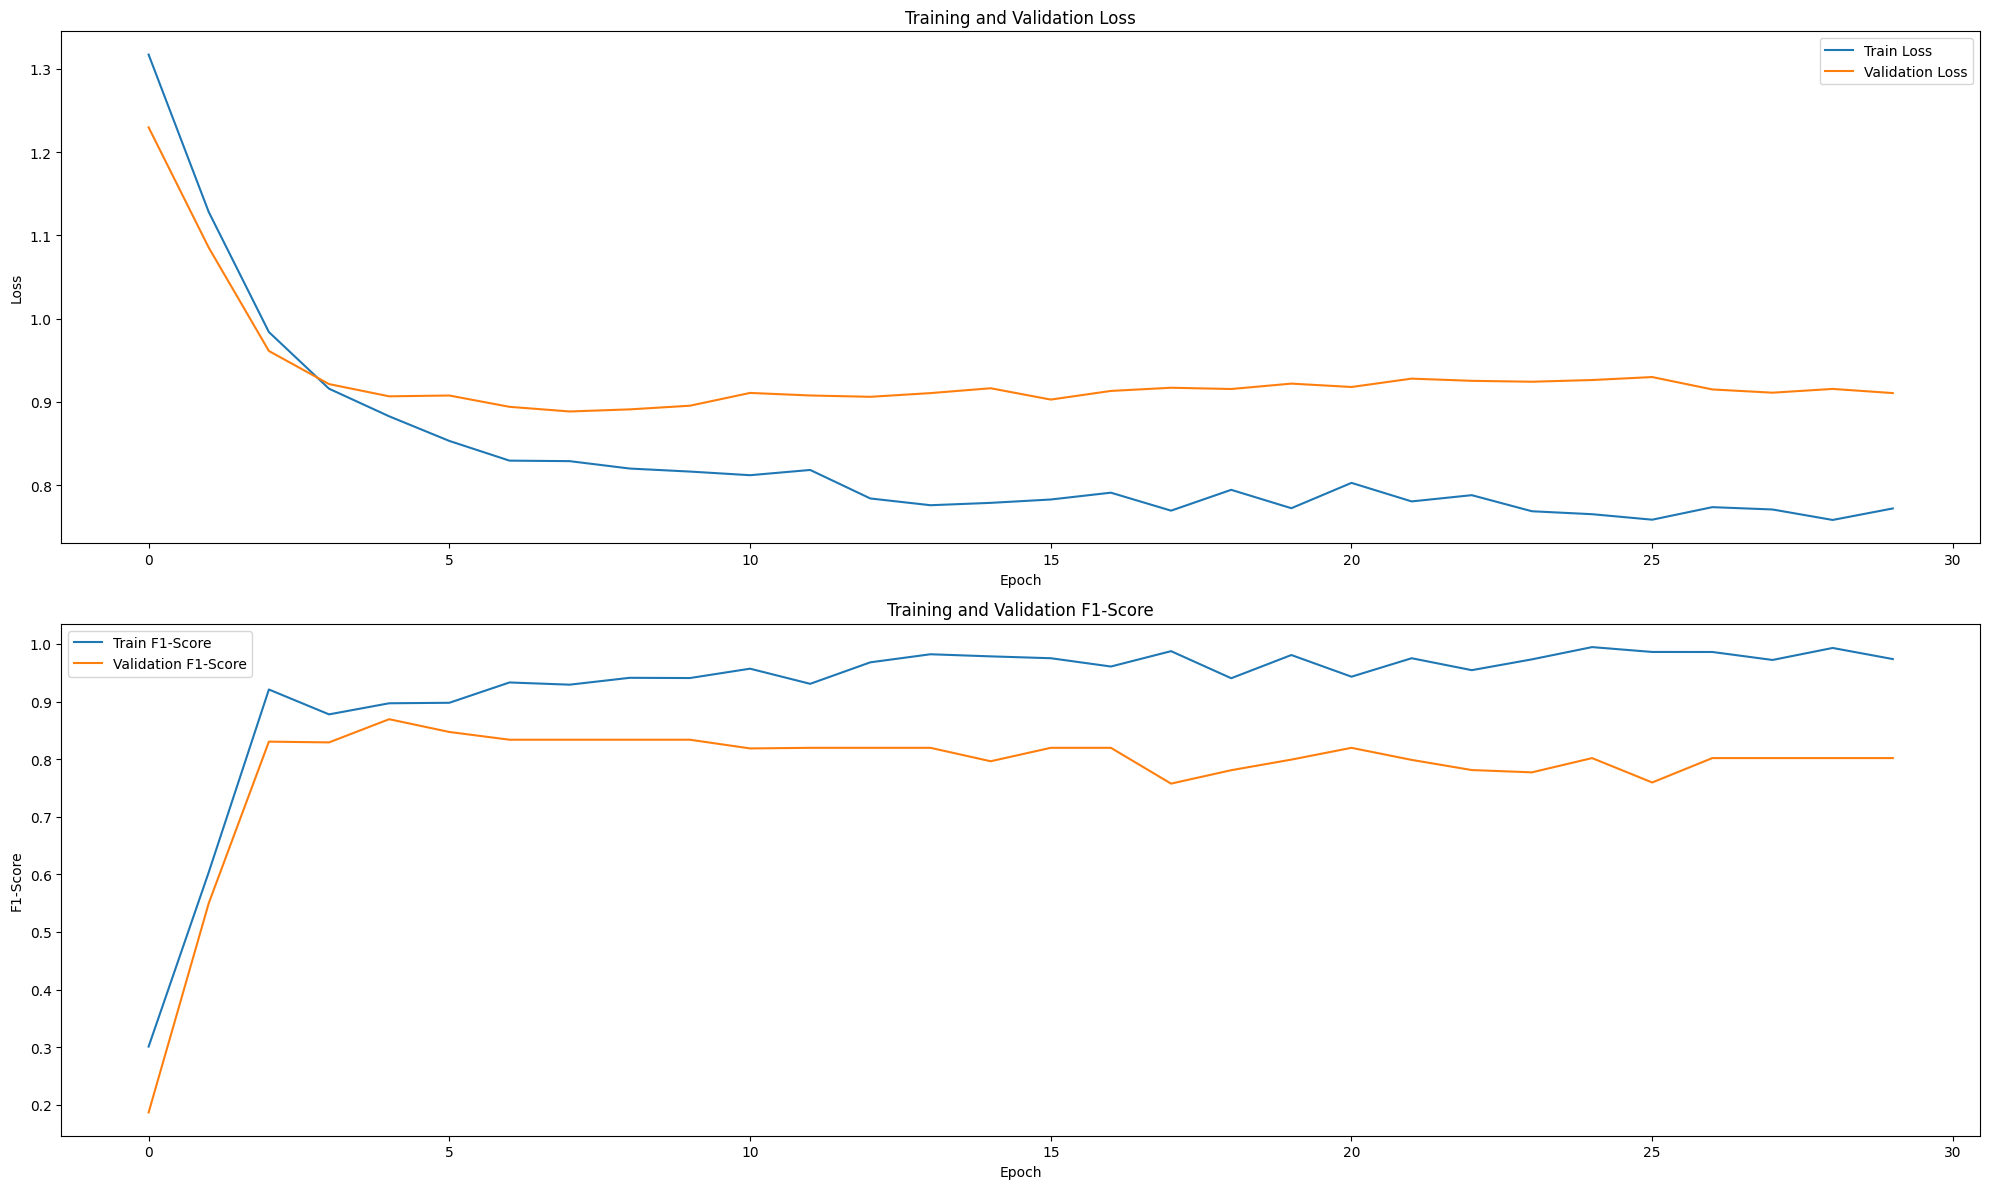

In [71]:
plot_training_results(history=history)

In [72]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9200, Precision: 0.9337, Recall: 0.8958, F1 Score: 0.9119
Classification Report : 

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       1.00      0.83      0.91         6
           2       0.91      0.83      0.87        12
           3       0.91      1.00      0.95        20

    accuracy                           0.92        50
   macro avg       0.93      0.90      0.91        50
weighted avg       0.92      0.92      0.92        50



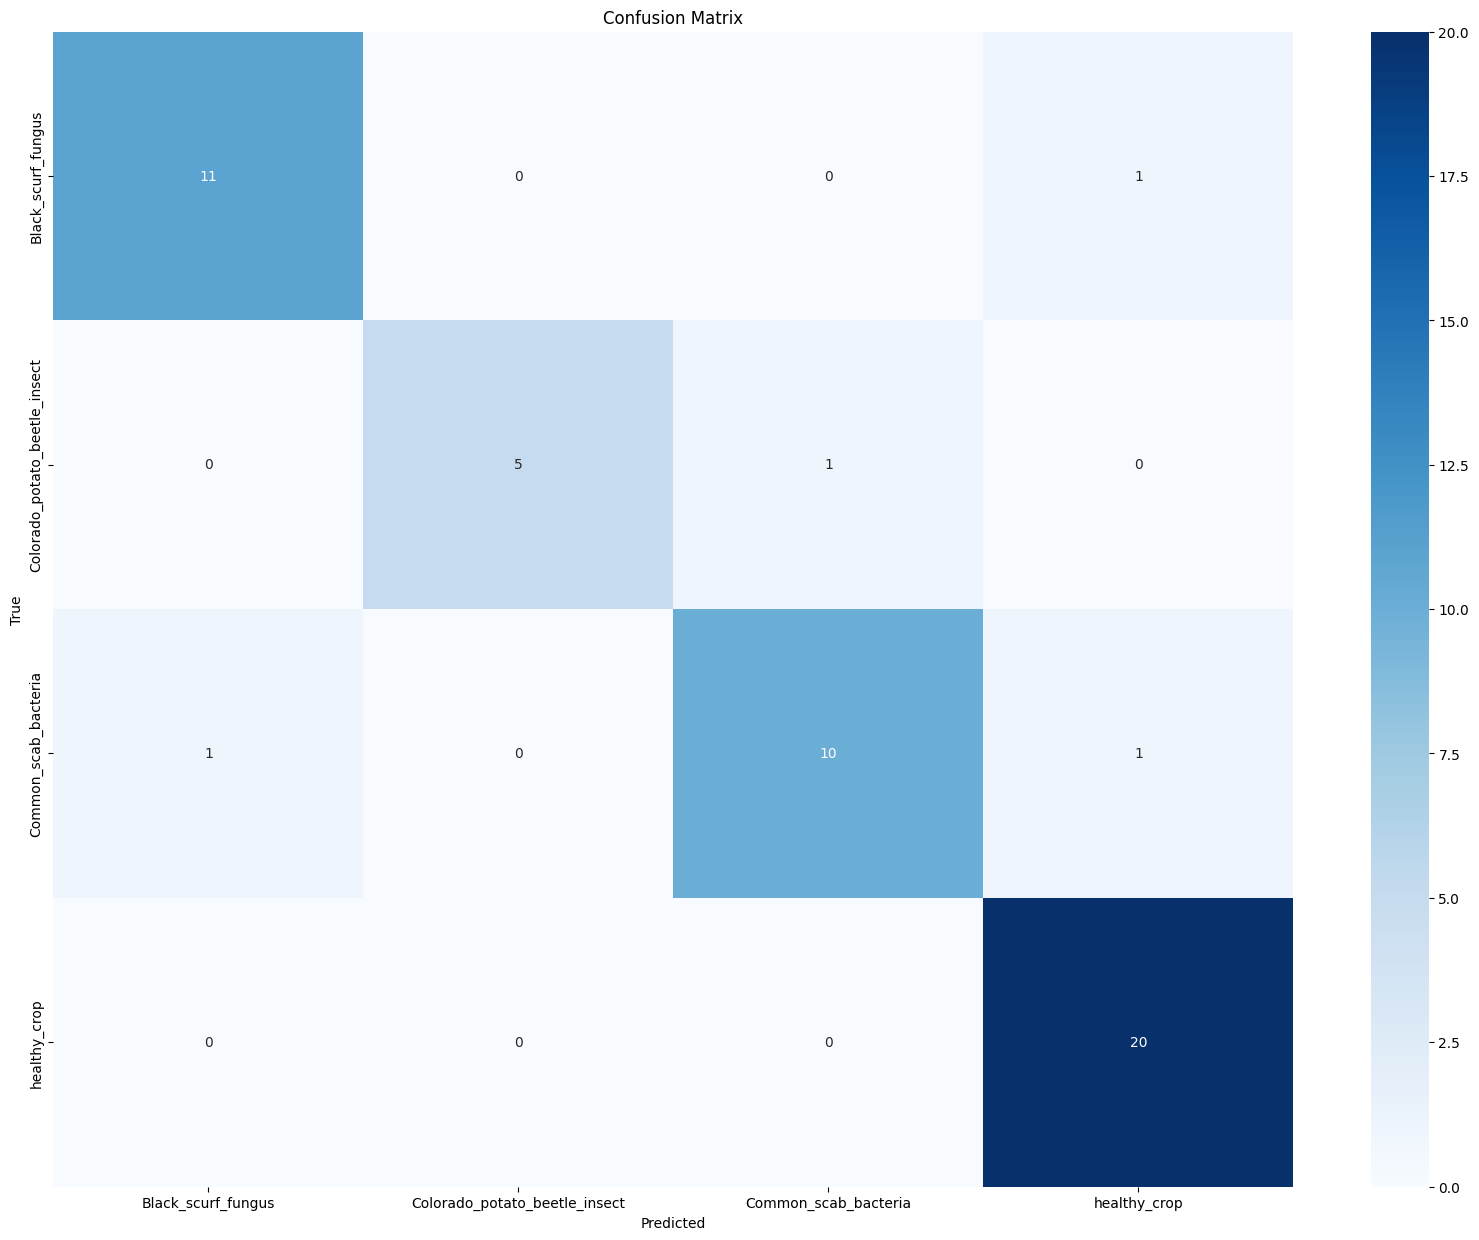

In [73]:
# plot confusion matrix
plot_cm(cm, class_names, title="Confusion Matrix")

###### With Augmentation and Class Weighting

In [109]:
# tweak these and experiment with different values.
config = dict(
    resize =256 ,
    crop = 240,
    augment = True,
    epochs = 30,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.3,
    weights_path = 'weighted_efficientnet_b0_weights_aug.pth'
)

In [110]:
es = EarlyStopping(patience=10, min_delta=0.01, restore_best_weights=False)

In [111]:
# Define paths
ROOT_DIR = 'cleaned-p'

# Get transformations (without augmentation)
# train_transform, val_transform =  get_transforms(augment=False)
train_transform, valid_transform = get_transforms(augment=config['augment'])

# Load datasets
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation', resize=config['resize'], transform=valid_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test', resize=config['resize'], transform=valid_transform)

# number of workers
nw = min([os.cpu_count(), config['batch_size'] if config['batch_size'] > 1 else 0, 8])

# class frequencies
class_freq = train_dataset.get_class_frequencies()

sample_weights = torch.from_numpy(np.array([1./x for x in class_freq.values()])).double()
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=nw)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=nw)

In [112]:
# Class names
class_names = train_dataset.class_names
class_dict = train_dataset.class_idx_to_name

In [121]:
total_samples = sum(class_freq.values())
num_classes = len(class_freq)

class_weights = [round(total_samples / (num_classes * class_freq[i]), 4) for i in range(num_classes)]
class_weights = [round(1./x, 4) for x in class_freq.values()]
print(class_weights)

[0.0286, 0.0556, 0.027, 0.0164]


In [122]:
# Initialize the model with best available pre-trained weights
model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)

# Freeze the pre-trained model parameters
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[1].in_features

# Modify the last fully connected layer
model.classifier = nn.Sequential(
    nn.Dropout(config['dropout']),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(config['dropout']),
    nn.Linear(512, len(class_names)),
    nn.Softmax(dim=1)
)

# Set up the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the specified device
model = model.to(device)

# Define optimizer and loss funtion4
optimizer = optim.Adam(params=model.parameters(), lr=config['lr'])

loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
#loss_fn = nn.CrossEntropyLoss()

In [123]:
# train and validate model performance
history = training_pipeline(
    config=config,
    model = model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    early_stopping=es,
    device=device
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
----------
Train - Loss: 1.3406, Accuracy: 0.5298, Precision: 0.4307, Recall: 0.5012, F1 Score: 0.4461


  3%|▎         | 1/30 [00:31<15:15, 31.59s/it]

Validation - Loss: 1.2385, Accuracy: 0.6400, Precision: 0.7789, Recall: 0.6242, F1 Score: 0.5901

Best model state saved
Epoch 2/30
----------
Train - Loss: 1.1262, Accuracy: 0.8212, Precision: 0.8689, Recall: 0.8309, F1 Score: 0.8045


  7%|▋         | 2/30 [01:01<14:14, 30.53s/it]

Validation - Loss: 1.0407, Accuracy: 0.7600, Precision: 0.8310, Recall: 0.7552, F1 Score: 0.7538
Improvement found, counter reset to 0
Best model state saved
Epoch 3/30
----------
Train - Loss: 0.9882, Accuracy: 0.8079, Precision: 0.7903, Recall: 0.8161, F1 Score: 0.8004


 10%|█         | 3/30 [01:35<14:33, 32.37s/it]

Validation - Loss: 0.9519, Accuracy: 0.8800, Precision: 0.8898, Recall: 0.8776, F1 Score: 0.8794
Improvement found, counter reset to 0
Best model state saved
Epoch 4/30
----------
Train - Loss: 0.8923, Accuracy: 0.9205, Precision: 0.9085, Recall: 0.9261, F1 Score: 0.9148


 13%|█▎        | 4/30 [02:09<14:10, 32.72s/it]

Validation - Loss: 0.9087, Accuracy: 0.9000, Precision: 0.9042, Recall: 0.9071, F1 Score: 0.9049
Improvement found, counter reset to 0
Best model state saved
Epoch 5/30
----------
Train - Loss: 0.8534, Accuracy: 0.9205, Precision: 0.9147, Recall: 0.9261, F1 Score: 0.9192


 17%|█▋        | 5/30 [02:40<13:29, 32.37s/it]

Validation - Loss: 0.8973, Accuracy: 0.9000, Precision: 0.9129, Recall: 0.8779, F1 Score: 0.8911
Improvement found, counter reset to 0
Best model state saved
Epoch 6/30
----------
Train - Loss: 0.8454, Accuracy: 0.9338, Precision: 0.9393, Recall: 0.9419, F1 Score: 0.9402


 20%|██        | 6/30 [03:12<12:48, 32.02s/it]

Validation - Loss: 0.8967, Accuracy: 0.8600, Precision: 0.8794, Recall: 0.8290, F1 Score: 0.8460
No improvement in the last 1 epochs
Best model state saved
Epoch 7/30
----------
Train - Loss: 0.8370, Accuracy: 0.9338, Precision: 0.9379, Recall: 0.9385, F1 Score: 0.9363


 23%|██▎       | 7/30 [03:43<12:08, 31.68s/it]

Validation - Loss: 0.8833, Accuracy: 0.8600, Precision: 0.8693, Recall: 0.8360, F1 Score: 0.8485
Improvement found, counter reset to 0
Best model state saved
Epoch 8/30
----------
Train - Loss: 0.8287, Accuracy: 0.9073, Precision: 0.9067, Recall: 0.9179, F1 Score: 0.9099


 27%|██▋       | 8/30 [04:14<11:32, 31.47s/it]

Validation - Loss: 0.8915, Accuracy: 0.8600, Precision: 0.8693, Recall: 0.8360, F1 Score: 0.8485
No improvement in the last 1 epochs
Best model state saved
Epoch 9/30
----------
Train - Loss: 0.8128, Accuracy: 0.9338, Precision: 0.9349, Recall: 0.9427, F1 Score: 0.9354


 30%|███       | 9/30 [04:44<10:50, 30.96s/it]

Validation - Loss: 0.8917, Accuracy: 0.8600, Precision: 0.8693, Recall: 0.8360, F1 Score: 0.8485
No improvement in the last 2 epochs
Best model state saved
Epoch 10/30
----------
Train - Loss: 0.8040, Accuracy: 0.9470, Precision: 0.9391, Recall: 0.9501, F1 Score: 0.9443


 33%|███▎      | 10/30 [05:17<10:34, 31.74s/it]

Validation - Loss: 0.9110, Accuracy: 0.8400, Precision: 0.8503, Recall: 0.8097, F1 Score: 0.8256
No improvement in the last 3 epochs
Best model state saved
Epoch 11/30
----------
Train - Loss: 0.8129, Accuracy: 0.9404, Precision: 0.9400, Recall: 0.9452, F1 Score: 0.9410


 37%|███▋      | 11/30 [05:48<09:59, 31.58s/it]

Validation - Loss: 0.8937, Accuracy: 0.8400, Precision: 0.8466, Recall: 0.8132, F1 Score: 0.8272
No improvement in the last 4 epochs
Best model state saved
Epoch 12/30
----------
Train - Loss: 0.8114, Accuracy: 0.9338, Precision: 0.9290, Recall: 0.9400, F1 Score: 0.9321


 40%|████      | 12/30 [06:19<09:22, 31.26s/it]

Validation - Loss: 0.8932, Accuracy: 0.8600, Precision: 0.8657, Recall: 0.8360, F1 Score: 0.8462
No improvement in the last 5 epochs
Best model state saved
Epoch 13/30
----------
Train - Loss: 0.8115, Accuracy: 0.9338, Precision: 0.9414, Recall: 0.9431, F1 Score: 0.9385


 43%|████▎     | 13/30 [06:50<08:50, 31.21s/it]

Validation - Loss: 0.8947, Accuracy: 0.8600, Precision: 0.8693, Recall: 0.8360, F1 Score: 0.8485
No improvement in the last 6 epochs
Best model state saved
Epoch 14/30
----------
Train - Loss: 0.8190, Accuracy: 0.9338, Precision: 0.9326, Recall: 0.9419, F1 Score: 0.9371


 47%|████▋     | 14/30 [07:21<08:19, 31.21s/it]

Validation - Loss: 0.9025, Accuracy: 0.8400, Precision: 0.8503, Recall: 0.8097, F1 Score: 0.8256
No improvement in the last 7 epochs
Best model state saved
Epoch 15/30
----------
Train - Loss: 0.7948, Accuracy: 0.9536, Precision: 0.9556, Recall: 0.9626, F1 Score: 0.9587


 50%|█████     | 15/30 [07:51<07:42, 30.87s/it]

Validation - Loss: 0.8849, Accuracy: 0.8800, Precision: 0.8844, Recall: 0.8844, F1 Score: 0.8844
No improvement in the last 8 epochs
Best model state saved
Epoch 16/30
----------
Train - Loss: 0.8313, Accuracy: 0.9139, Precision: 0.9058, Recall: 0.9186, F1 Score: 0.9117


 53%|█████▎    | 16/30 [08:22<07:13, 30.94s/it]

Validation - Loss: 0.8871, Accuracy: 0.8600, Precision: 0.8606, Recall: 0.8651, F1 Score: 0.8611
No improvement in the last 9 epochs
Best model state saved
Epoch 17/30
----------
Train - Loss: 0.7906, Accuracy: 0.9669, Precision: 0.9553, Recall: 0.9715, F1 Score: 0.9618


 53%|█████▎    | 16/30 [08:56<07:49, 33.53s/it]

Validation - Loss: 0.8856, Accuracy: 0.8800, Precision: 0.8844, Recall: 0.8844, F1 Score: 0.8844
Early stopping triggered after 10 epochs.
Best model saved in artifacts folder


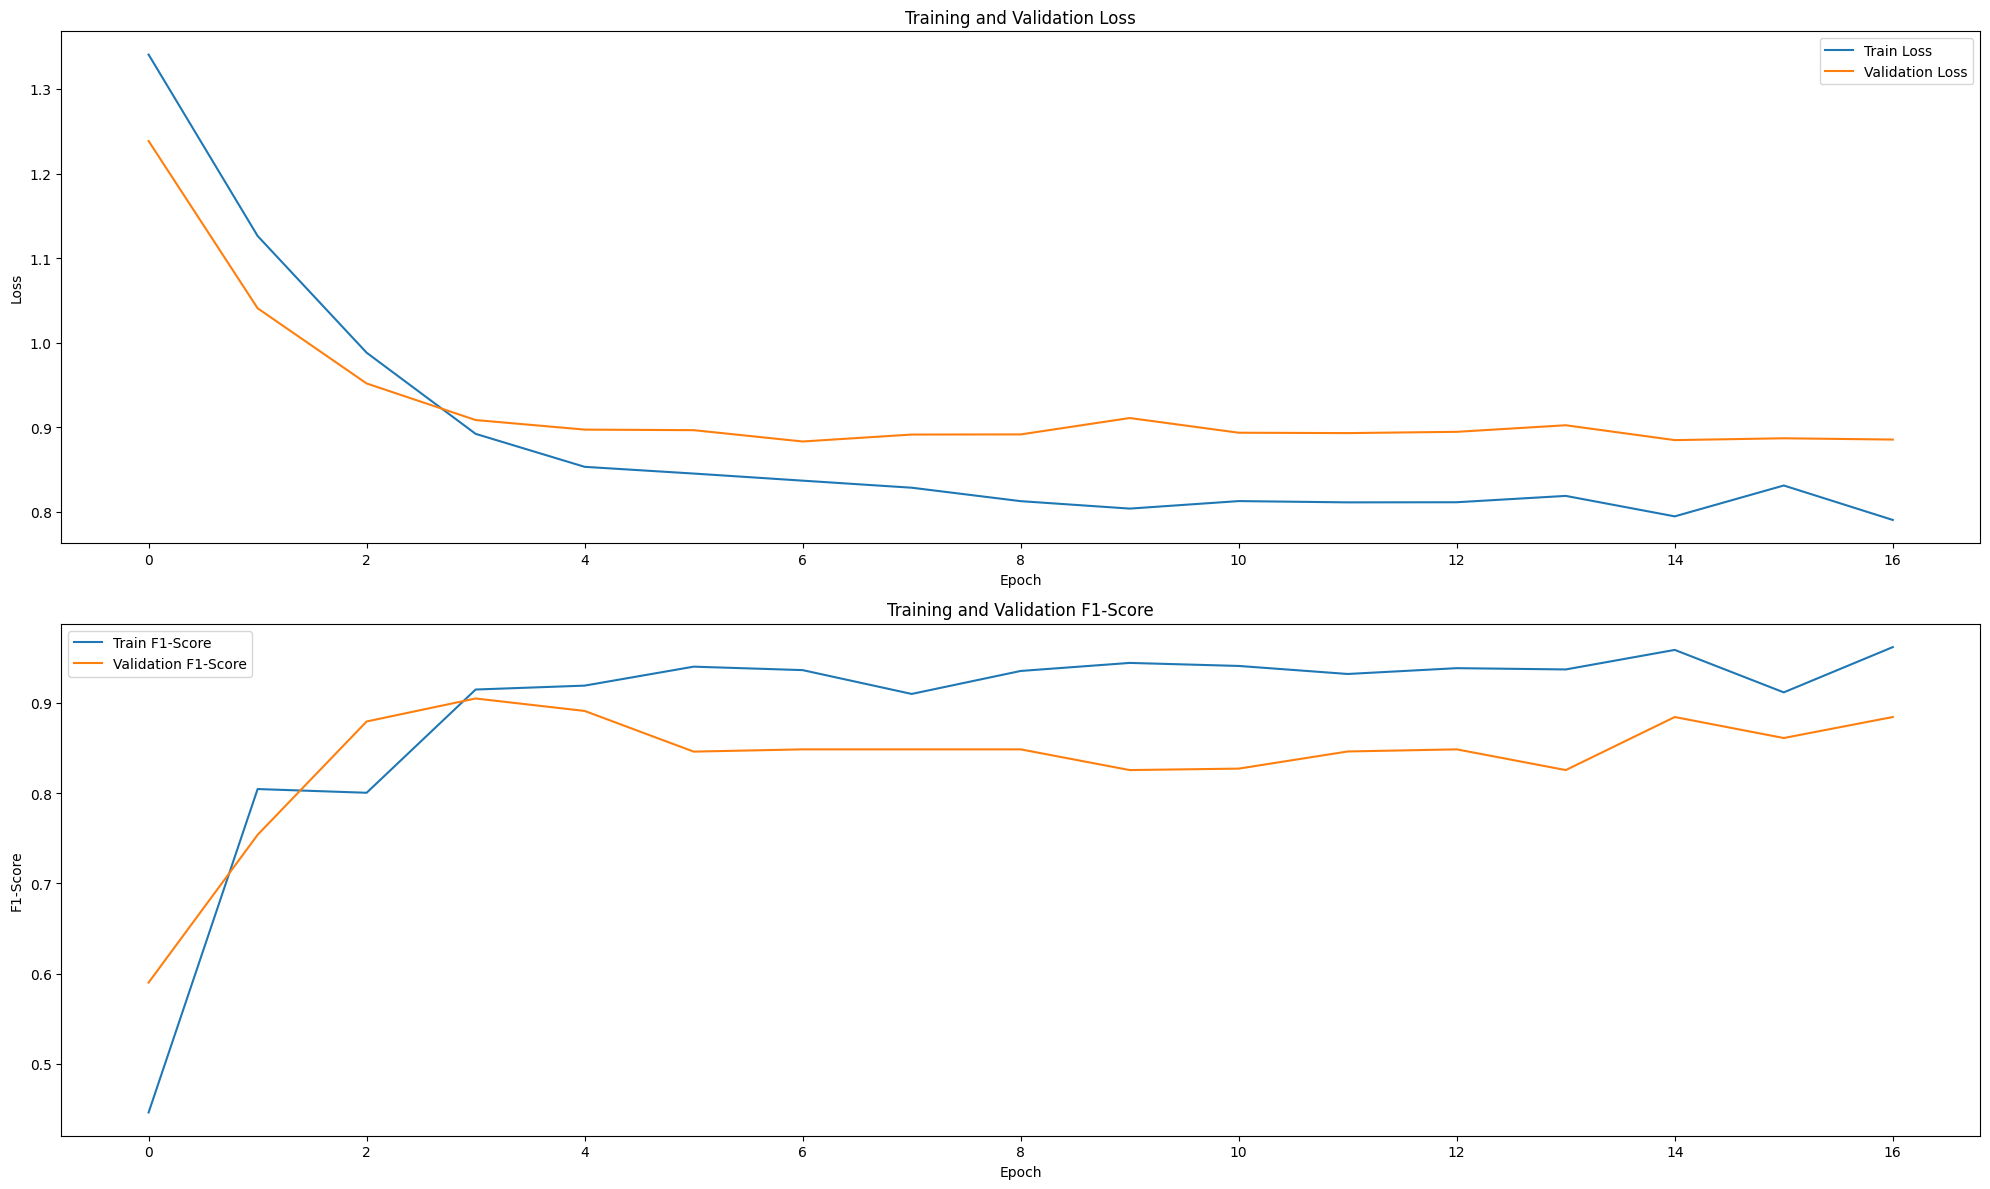

In [124]:
plot_training_results(history=history)

In [125]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model, test_loader=test_loader, device=device)
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9400, Precision: 0.9564, Recall: 0.9375, F1 Score: 0.9445
Classification Report : 

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       1.00      1.00      1.00         6
           2       1.00      0.83      0.91        12
           3       0.91      1.00      0.95        20

    accuracy                           0.94        50
   macro avg       0.96      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



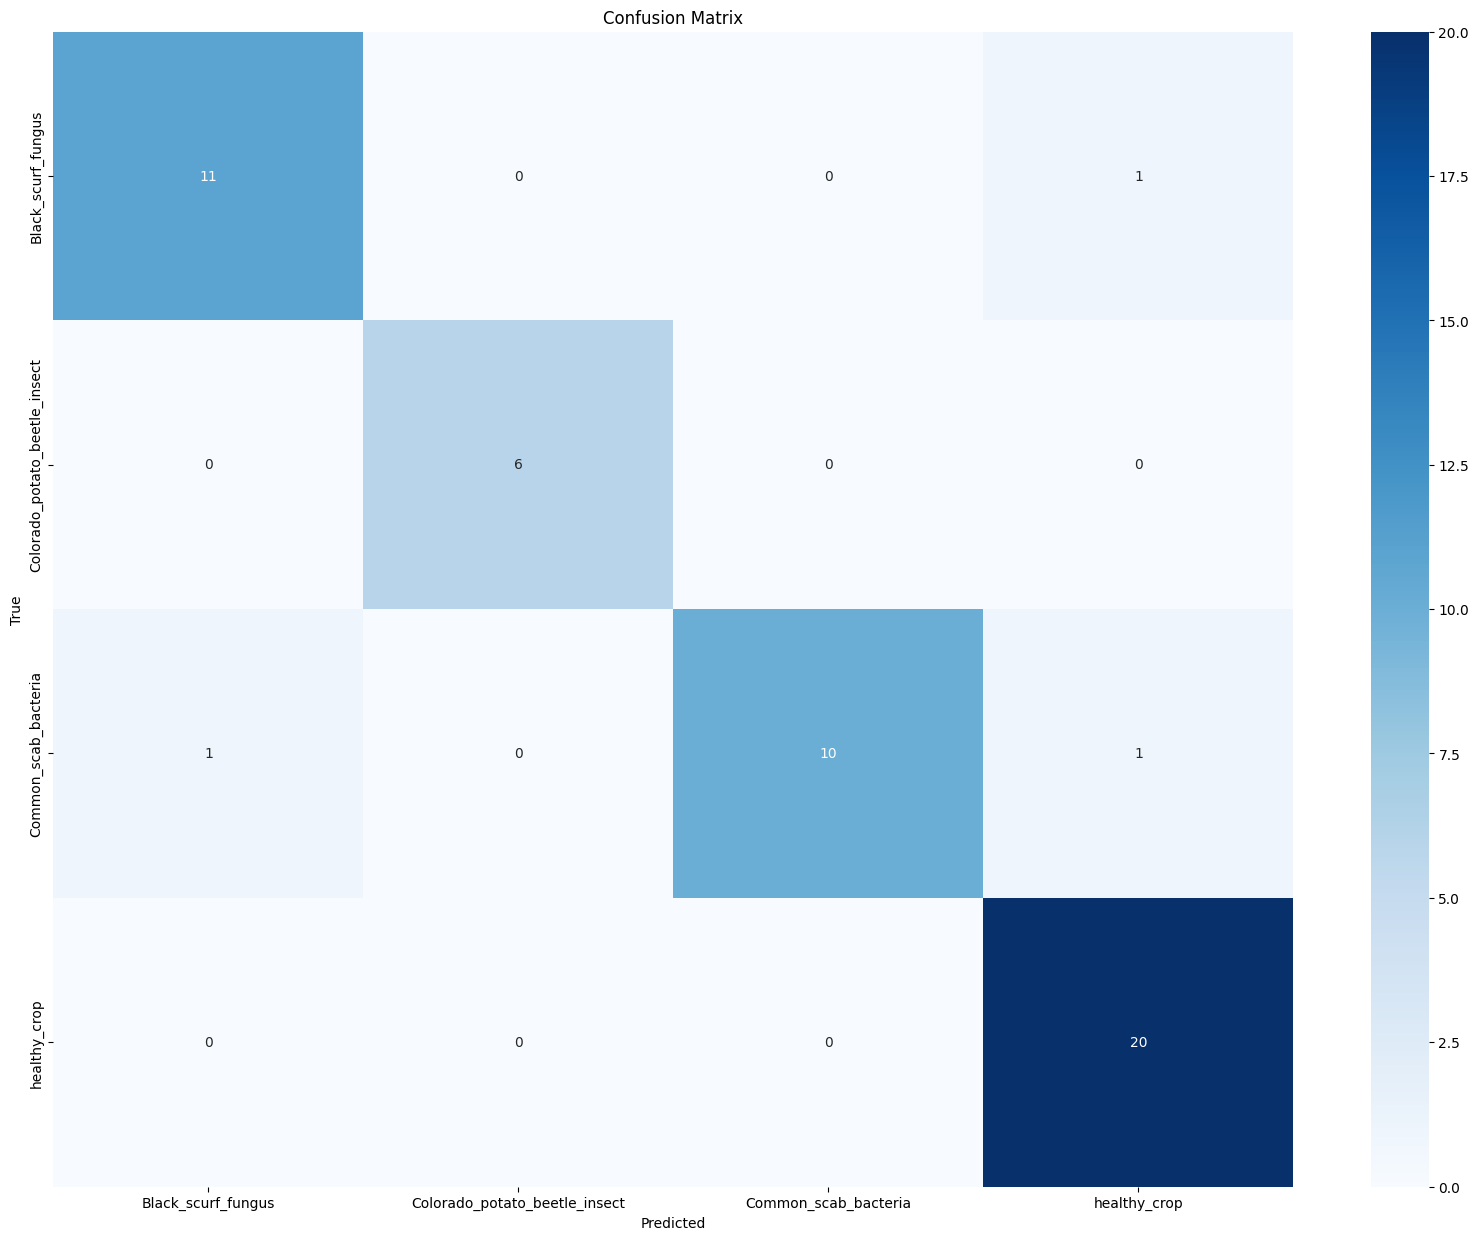

In [126]:
# plot confusion matrix
plot_cm(cm, class_names, title="Confusion Matrix")

## Experiment Results & Prediction Pipeline

###### Experiment Summary

In [136]:
# Data as a dictionary
exp1 = { "Model": "resnet50_bas.pth", "Accuracy": 0.9000, "Precision": 0.9118, "Recall": 0.8542, "F1 Score": 0.8728 }
exp2 = { "Model": "resnet50_aug.pth", "Accuracy": 0.9200, "Precision": 0.9022, "Recall": 0.8958, "F1 Score": 0.8968 }
exp3 = { "Model": "efficientnet_b0_bas.pth", "Accuracy": 0.8600, "Precision": 0.8794, "Recall": 0.8333, "F1 Score": 0.8441 }
exp4 = { "Model": "efficientnet_b0_aug.pth", "Accuracy": 0.9200, "Precision": 0.9337, "Recall": 0.8958, "F1 Score": 0.9119 }
exp5 = { "Model": "weighted_efficientnet_b0_aug.pth", "Accuracy": 0.9400, "Precision": 0.9564, "Recall": 0.9375, "F1 Score": 0.9445 }

data = [exp1, exp2, exp3, exp4, exp5]
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Print the DataFrame (optional)
df.sort_values(by='F1 Score', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
4,weighted_efficientnet_b0_aug.pth,0.94,0.9564,0.9375,0.9445
3,efficientnet_b0_aug.pth,0.92,0.9337,0.8958,0.9119
1,resnet50_aug.pth,0.92,0.9022,0.8958,0.8968
0,resnet50_bas.pth,0.90,0.9118,0.8542,0.8728
2,efficientnet_b0_bas.pth,0.86,0.8794,0.8333,0.8441


###### Prediction Pipeline

In [15]:
weights_path = 'artifacts/weighted_efficientnet_b0_weights_aug.pth'
class_dict = {0: 'Black_scurf_fungus', 1: 'Colorado_potato_beetle_insect', 2: 'Common_scab_bacteria', 3: 'healthy_crop'}

In [16]:
config = dict(
    resize =256 ,
    crop = 240,
    augment= False,
    dropout = 0.3,
    batch_size=32
)

In [17]:
def load_model(weights_path: str, device: str, config:Dict, num_classes: int=4):
    # Initialize the model
    model = efficientnet_b0(weights=None)

    num_ftrs = model.classifier[1].in_features

    # Freeze the pre-trained model parameters
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
                    nn.Dropout(p=config["dropout"], inplace=True),
                    nn.Linear(num_ftrs, 512),
                    nn.ReLU(),
                    nn.Dropout(p=config["dropout"]),
                    nn.Linear(512, num_classes)
                    )

    # Load the saved model weights
    model_weights = torch.load(weights_path)
    model.load_state_dict(model_weights)

    # Set the model to evaluation mode and move it to the specified device
    model.eval().to(device)

    return model

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
model = load_model(weights_path=weights_path, device=device, config=config)

In [20]:
# Define paths
play_dir = 'playset'
ROOT_DIR = 'cleaned-p'

# Get transformations (without augmentation)
train_transform, valid_transform = get_transforms(augment=config['augment'])

# Load datasets
#play_dataset = datasets.ImageFolder(play_dir, transform=transforms)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test', resize=config['resize'], transform=valid_transform)
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train', resize=config['resize'], transform=valid_transform)

# Define data loaders
#play_loader = DataLoader(play_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

In [21]:
def calculate_energy(outputs):
    return -torch.logsumexp(outputs, dim=1)

def analyze_energy_distribution(model, dataloader, device):
    model.eval()
    energies = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            energy = calculate_energy(outputs)
            energies.extend(energy.cpu().numpy())
    return energies

energies = analyze_energy_distribution(model, test_loader, device)

energy_threshold = np.percentile(energies, 95)

print(f"Energy Threshold: {energy_threshold}")
print(len(energies), np.max(energies), np.min(energies), np.mean(energies))

Energy Threshold: -1.7551842093467716
50 -1.449152 -6.860721 -3.4917002


In [79]:
energies = analyze_energy_distribution(model, train_loader, device)

energy_threshold = np.percentile(energies, 95)

print(f"Energy Threshold: {energy_threshold}")
print(len(energies), np.max(energies), np.min(energies), np.mean(energies))

Energy Threshold: -1.8754281997680664
151 -1.4285951 -8.363508 -3.8702788


In [49]:
from PIL import Image

def inference(user_input, model, class_dict, device='cpu', energy_threshold=None):

    # Get the image
    image = Image.open(user_input)

    # Move model to the device
    model.to(device)
    model.eval() # set the model to evaluation mode

    # Define the transformation for the image
    transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #model specific
        ToTensorV2()
    ])

    # Apply this transformation to the image
    image = transform(image=np.array(image))['image']

    image_tensor = image.clone().detach().unsqueeze(0).to(device)

    # finally put the image tensor into your trained model
    with torch.inference_mode():
        output = model(image_tensor)

    # Convert output to probabilities with softmax
    p = torch.softmax(output, dim=1)
    energy = -torch.logsumexp(output, dim=1)

    # Get highest probability from the prediction(tensor) and return its value & index(predicted class)
    probability, predicted_class = torch.max(p, dim=1)
    class_name = class_dict[predicted_class.item()]

    if energy_threshold:
      if (energy > energy_threshold) and (probability < 0.6):
          # print(f" Unknown image")
          class_name = 'Unknown'

    #return round(probability.item(), 4), predicted_class.item(), class_name
    return {
      "probability": round(probability.item(), 4),
      "class": class_name,
      "energy": energy.item(),
      #"output": output
    }


In [50]:
def get_inference(img_dir, inference, model, class_dict, device):
  """
  Performs inference on images, stores results in a DataFrame, and returns it.

  Args:
      img_dir (str): directory of images for prediction.
      inference (function): Function to perform inference on an image.
      model (nn.Module): PyTorch model for prediction.
      class_dict (dict): Dictionary mapping class indices to class names.
      device (str): Device to use for inference (e.g., 'cpu' or 'cuda').

  Returns:
      pandas.DataFrame: DataFrame containing prediction results.
  """
  # energy_thresh = -1.8754281997680664

  # Get list of image paths and names
  play_imgs = [x.path for x in os.scandir(img_dir)]
  play_names = [x.name for x in os.scandir(img_dir)]

  # Create empty list to store results
  results = []

  # Perform inference on each image
  for img, name in zip(play_imgs, play_names):
    # p, c, e = inference(img, model, class_dict, energy_thresh, device).values()
    p, c, e = inference(img, model, class_dict, device).values()

    results.append([name, c, p, e]) # Append results to the list

  # Create DataFrame from results
  return pd.DataFrame(results, columns=["Image File", "Class", "Probability", "Energy"])

In [51]:
df = get_inference(play_dir, inference, model, class_dict, device)

In [52]:
df.sort_values(by='Energy', ascending=False)

,Image File,Class,Probability,Energy
1,spoon_2.jpeg,Colorado_potato_beetle_insect,0.3666,-1.301889
0,spoon_1.jpeg,healthy_crop,0.3683,-1.361052
15,healthy_crop_4.jpeg,healthy_crop,0.3924,-1.395649
13,healthy_crop_2.jpeg,Common_scab_bacteria,0.3782,-1.418812
14,healthy_crop_3.jpeg,healthy_crop,0.3408,-1.472999
3,cat.jpeg,Colorado_potato_beetle_insect,0.4090,-1.486623
12,healthy_crop_1.jpeg,healthy_crop,0.6074,-1.542039
11,dog.jpeg,Colorado_potato_beetle_insect,0.5594,-1.564600
16,red_tomato.jpeg,Colorado_potato_beetle_insect,0.5789,-1.971911
9,Common_scab_bacteria_2.jpeg,Common_scab_bacteria,0.6160,-1.981317
